# Chapter 4 - Exploring Financial Time Series Data

시계열 데이타의 여러 특성들을 살펴 보자.

- 이동 통계값을 이용해서 이상치 찾기
- Hampel filter를 이용해서 이상치 찾기
- 시계열에서 변화점 찾기
- 시계열에서 추세 찾기
- Hurst exponent를 이용해서 시계열에서 여러 패턴 찾기
- 자산 수익률의 여러 정형화된 사실들 조사하기
  - Fact 1: 수익률은 가우시안 분포가 아니다
  - Fact 2: 변동성이 몰려 있다.
  - Fact 3: 수익률은 자기상관 관계가 없다.
  - Fact 4: 제곱/절대 수익률은 작고 감소하는 자기상관 값을 갖는다
  - Fact 5: 지렛대 효과

## 4.1 Outlier detection using rolling statistics

금융 분야에서 가능한 이상치 값들
- 잘못된 가격
- 금융시장에서 중요한 사건 발생
- 데이터 가공 과정에서 에러 발생

머신러닝이나 통계 분석을 할 때 이상치 값에 영향을 받아서 잘못된 분석이 될 수 있다.
따라서 분석전에 이상치 값을 확인하고 처리해야 한다.

이동 통계를 이용해서 이상치를 찾는 방법
- 지정된 윈도우(구간)를 이동하면서 이동통계를 구한다. 평균과 표준편차를 구한다.
- 평균에서 표준편차의 지정된 배수만큼보다 더 벗어난 값들을 확인다.

예제
- 윈도우(구간)은 21
- 표준편차 3배수 (99.7%의 값)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

pandas 1.3.5에서는 아래 오류가 발생하지 않음.
~~>오류 발생 부분~~  
~~`from pandas.core.common import SettingWithCopyWarning`~~

~~>변경~~  
~~`from pandas.errors import SettingWithCopyWarning`~~

In [3]:
import pandas as pd 
import yfinance as yf

2019년부터 2020년까지의 테슬라 주가정보를 얻어오고 단순 수익률을 구한다

In [4]:
df = yf.download("TSLA", 
                 start="2019-01-01", 
                 end="2020-12-31",
                 progress=False)

df["rtn"] = df["Adj Close"].pct_change()
df = df[["rtn"]].copy()
df.head()


rtn
Date                
2019-01-02       NaN
2019-01-03 -0.031472
2019-01-04  0.057697
2019-01-07  0.054361
2019-01-08  0.001164

이동 평균과 이동 표준편차를 구한다.

In [5]:
df_rolling = df[["rtn"]].rolling(window=21) \
                        .agg(["mean", "std"])
#df_rolling.columns = df_rolling.columns.droplevel()
df_rolling

rtn          
                mean       std
Date                          
2019-01-02       NaN       NaN
2019-01-03       NaN       NaN
2019-01-04       NaN       NaN
2019-01-07       NaN       NaN
2019-01-08       NaN       NaN
...              ...       ...
2020-12-23  0.011014  0.041006
2020-12-24  0.009119  0.039307
2020-12-28  0.007660  0.038922
2020-12-29  0.006850  0.038819
2020-12-30  0.010384  0.038578

[504 rows x 2 columns]

In [6]:
df_rolling = df[["rtn"]].rolling(window=21) \
                        .agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel()
df_rolling

mean       std
Date                          
2019-01-02       NaN       NaN
2019-01-03       NaN       NaN
2019-01-04       NaN       NaN
2019-01-07       NaN       NaN
2019-01-08       NaN       NaN
...              ...       ...
2020-12-23  0.011014  0.041006
2020-12-24  0.009119  0.039307
2020-12-28  0.007660  0.038922
2020-12-29  0.006850  0.038819
2020-12-30  0.010384  0.038578

[504 rows x 2 columns]

이동 통계값을 원래 데이터프레임에 합친다.

In [7]:
df = df.join(df_rolling)
df.head()

rtn  mean  std
Date                           
2019-01-02       NaN   NaN  NaN
2019-01-03 -0.031472   NaN  NaN
2019-01-04  0.057697   NaN  NaN
2019-01-07  0.054361   NaN  NaN
2019-01-08  0.001164   NaN  NaN

평균 위/아래 범위값을 설정한다.

In [8]:
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]

범위값을 벗어나는 값들을 확인한다.

In [9]:
df["outlier"] = (
    (df["rtn"] > df["upper"]) | (df["rtn"] < df["lower"])
)

수익률을 범위와 같이 표시하고 이상치 값들을 점으로 표시한다.

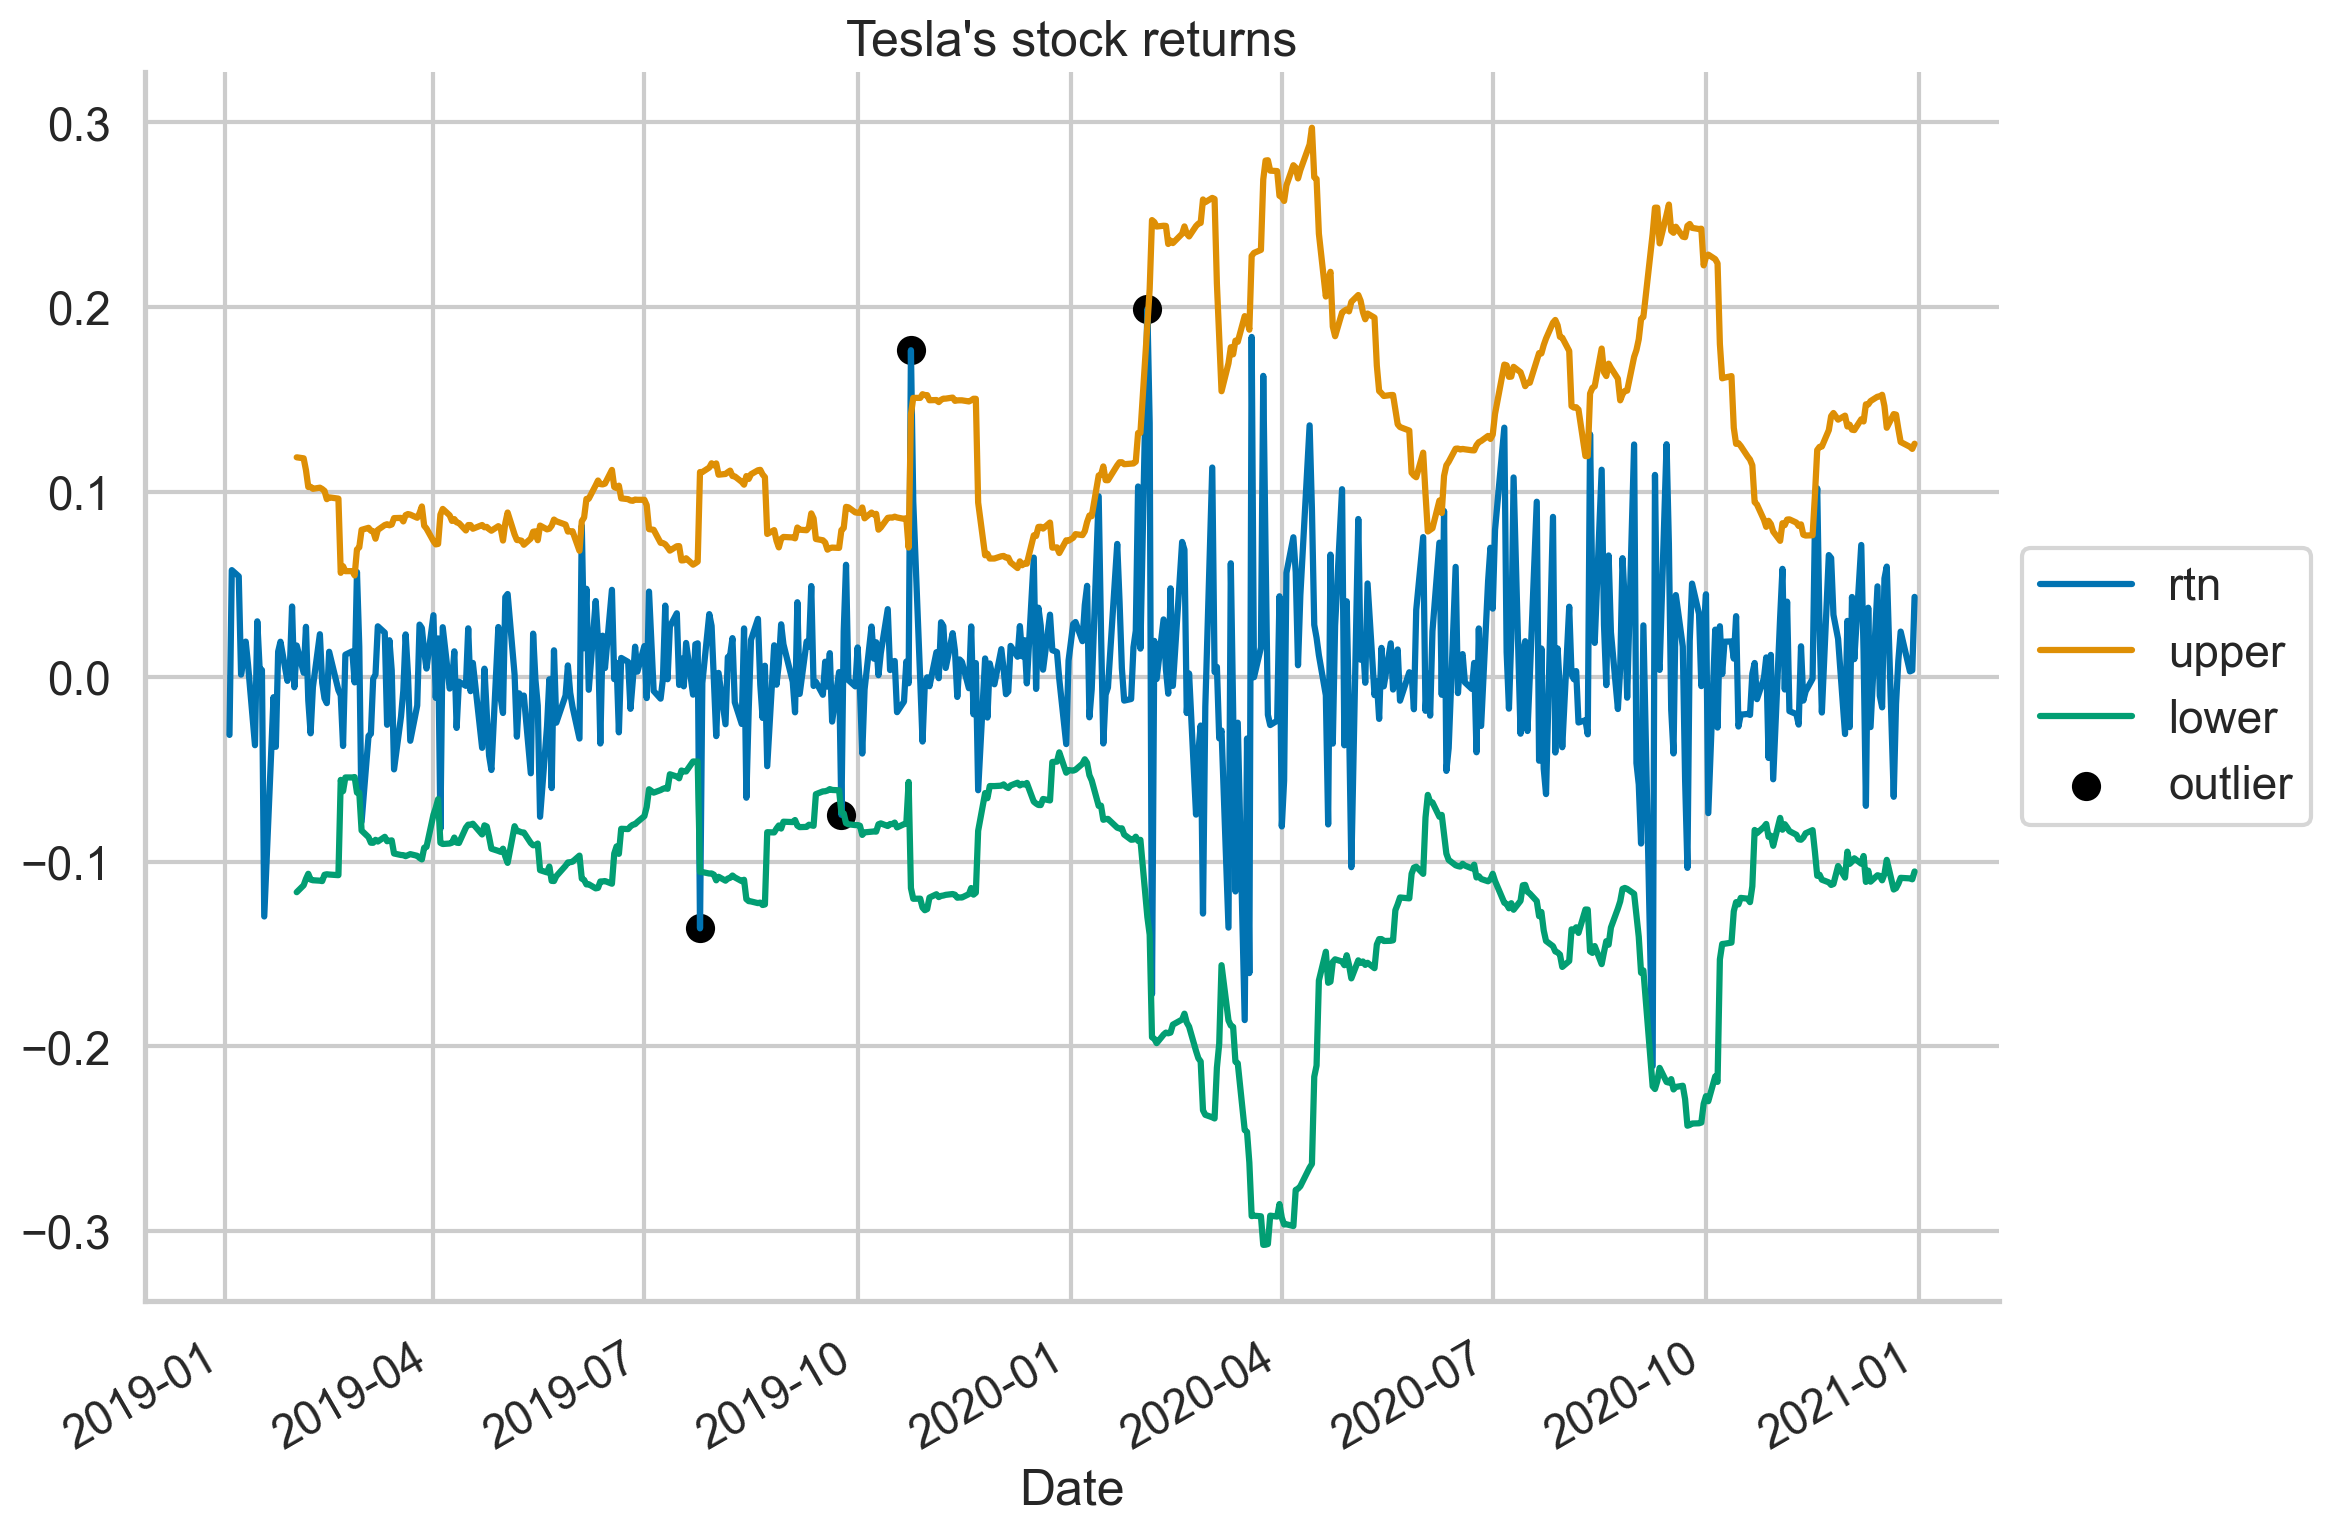

In [10]:
fig, ax = plt.subplots()

df[["rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "rtn"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_1", dpi=200)

이동 평균 관련 설명
- Window를 21로 설정한 것은 1달 이동 평균을 사용하기 위해서
- Window가 작으면 더 빨리 반응하고 크면 느리게 반응한다.
- 이동 평균을 가중 이동 평균을 사용할 수 있다.
- 지금 방법은 이상치 판단을 하는 시점의 과거 21일의 평균/표준편차를 이용한다. 판단시점의 앞 10일과 뒤 10일을 이용하는 방법을 사용할 수도 있다.
  - rolling 함수의 center 인자를 사용

실제 사용할 때는 찾은 이상치 값을 처리해야 한다.
- 적당한 최대/최소 값으로 바꾸는 방법
- 중간 값으로 바꾸는 방법 등..

앞에서 실행한 이상치를 찾는 기능을 함수 (identify_outliers)로 만들고 확인한다.

In [11]:
def identify_outliers(df, column, window_size, n_sigmas):
    """Function for identifying outliers using rolling statistics"""
    
    df = df[[column]].copy()
    df_rolling = df.rolling(window=window_size) \
                   .agg(["mean", "std"])
    df_rolling.columns = df_rolling.columns.droplevel()
    df = df.join(df_rolling)
    df["upper"] = df["mean"] + n_sigmas * df["std"]
    df["lower"] = df["mean"] - n_sigmas * df["std"]
    
    return ((df[column] > df["upper"]) | (df[column] < df["lower"]))
    

In [12]:
identify_outliers(df, "rtn", 21, 3)

Date
2019-01-02    False
2019-01-03    False
2019-01-04    False
2019-01-07    False
2019-01-08    False
              ...  
2020-12-23    False
2020-12-24    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
Length: 504, dtype: bool

## 4.2 Outlier detection with the Hampel filter

Hampel filter를 이용해서 이상치를 찾는 방법
- sktime 라이브러리에서 HampelFilter 클래스를 가져온다.
- HampelFilter의 fit_transform 함수를 사용해서 이상치 값을 확인한다.

Hampel filter에 대한 설명
- 지정한 윈도우의 중위값과 중앙 절대 편차를 이용해서 이상치를 확인
- 중앙 절대 편차 (MAD: Median absolute deviation)
  - 관측값에서 중앙값을 뺀 값의 절대값들의 중앙값
  - https://ko.wikipedia.org/wiki/%EC%A4%91%EC%95%99%EA%B0%92_%EC%A0%88%EB%8C%80_%ED%8E%B8%EC%B0%A8
- 중앙 절대 편차에 상수(constant scaling factor k)를 곱하면 표준 편차에 대한 일관된 추정값으로 사용할 수 있다.
  - 가우시안 분포일 때 k의 근사값은 1.4826

In [13]:
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

sktime 0.29.1에서는 발생하지 않음  
~~>오류 발생 부분~~  
~~`from sktime.transformations.series.outlier_detection import HampelFilter`~~  
~~>부분에서 UnicodeDecodeError 발생~~  
~~`UnicodeDecodeError: 'cp949' codec can't decode byte 0xe2 in position 4505: illegal multibyte sequence`~~  
~~>_estimator_html_repr.css 파일의 인코딩을 DOS(cp437)로 바꿔서 저장~~


### 테슬라의 종가들 중에서 이상치를 구해 본다.

2019년부터 2020년까지의 테슬라 주가정보를 얻어오고 단순 수익률을 구한다

In [14]:
df = yf.download("TSLA", 
                 start="2019-01-01", 
                 end="2020-12-31",
                 progress=False)
df["rtn"] = df["Adj Close"].pct_change()

HampelFilter의 instance를 만들고 fit_transform 함수를 사용해서 이상치를 구한다.  
이때 윈도우는 10이고 앞 5개, 뒤 5개의 값을 이용한다.

In [15]:
hampel_detector = HampelFilter(window_length=5, 
                               return_bool=True)
df["outlier"] = hampel_detector.fit_transform(df["Adj Close"])
df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-01-02  20.406668  21.008667  19.920000  20.674667  20.674667  174879000   
2019-01-03  20.466667  20.626667  19.825333  20.024000  20.024000  104478000   
2019-01-04  20.400000  21.200001  20.181999  21.179333  21.179333  110911500   
2019-01-07  21.448000  22.449333  21.183332  22.330667  22.330667  113268000   
2019-01-08  22.797333  22.934000  21.801332  22.356667  22.356667  105127500   

                 rtn  outlier  
Date                           
2019-01-02       NaN    False  
2019-01-03 -0.031472    False  
2019-01-04  0.057697    False  
2019-01-07  0.054361    False  
2019-01-08  0.001164    False

테슬라의 주가를 그래프로 그리고 이상치를 점으로 표시한다.

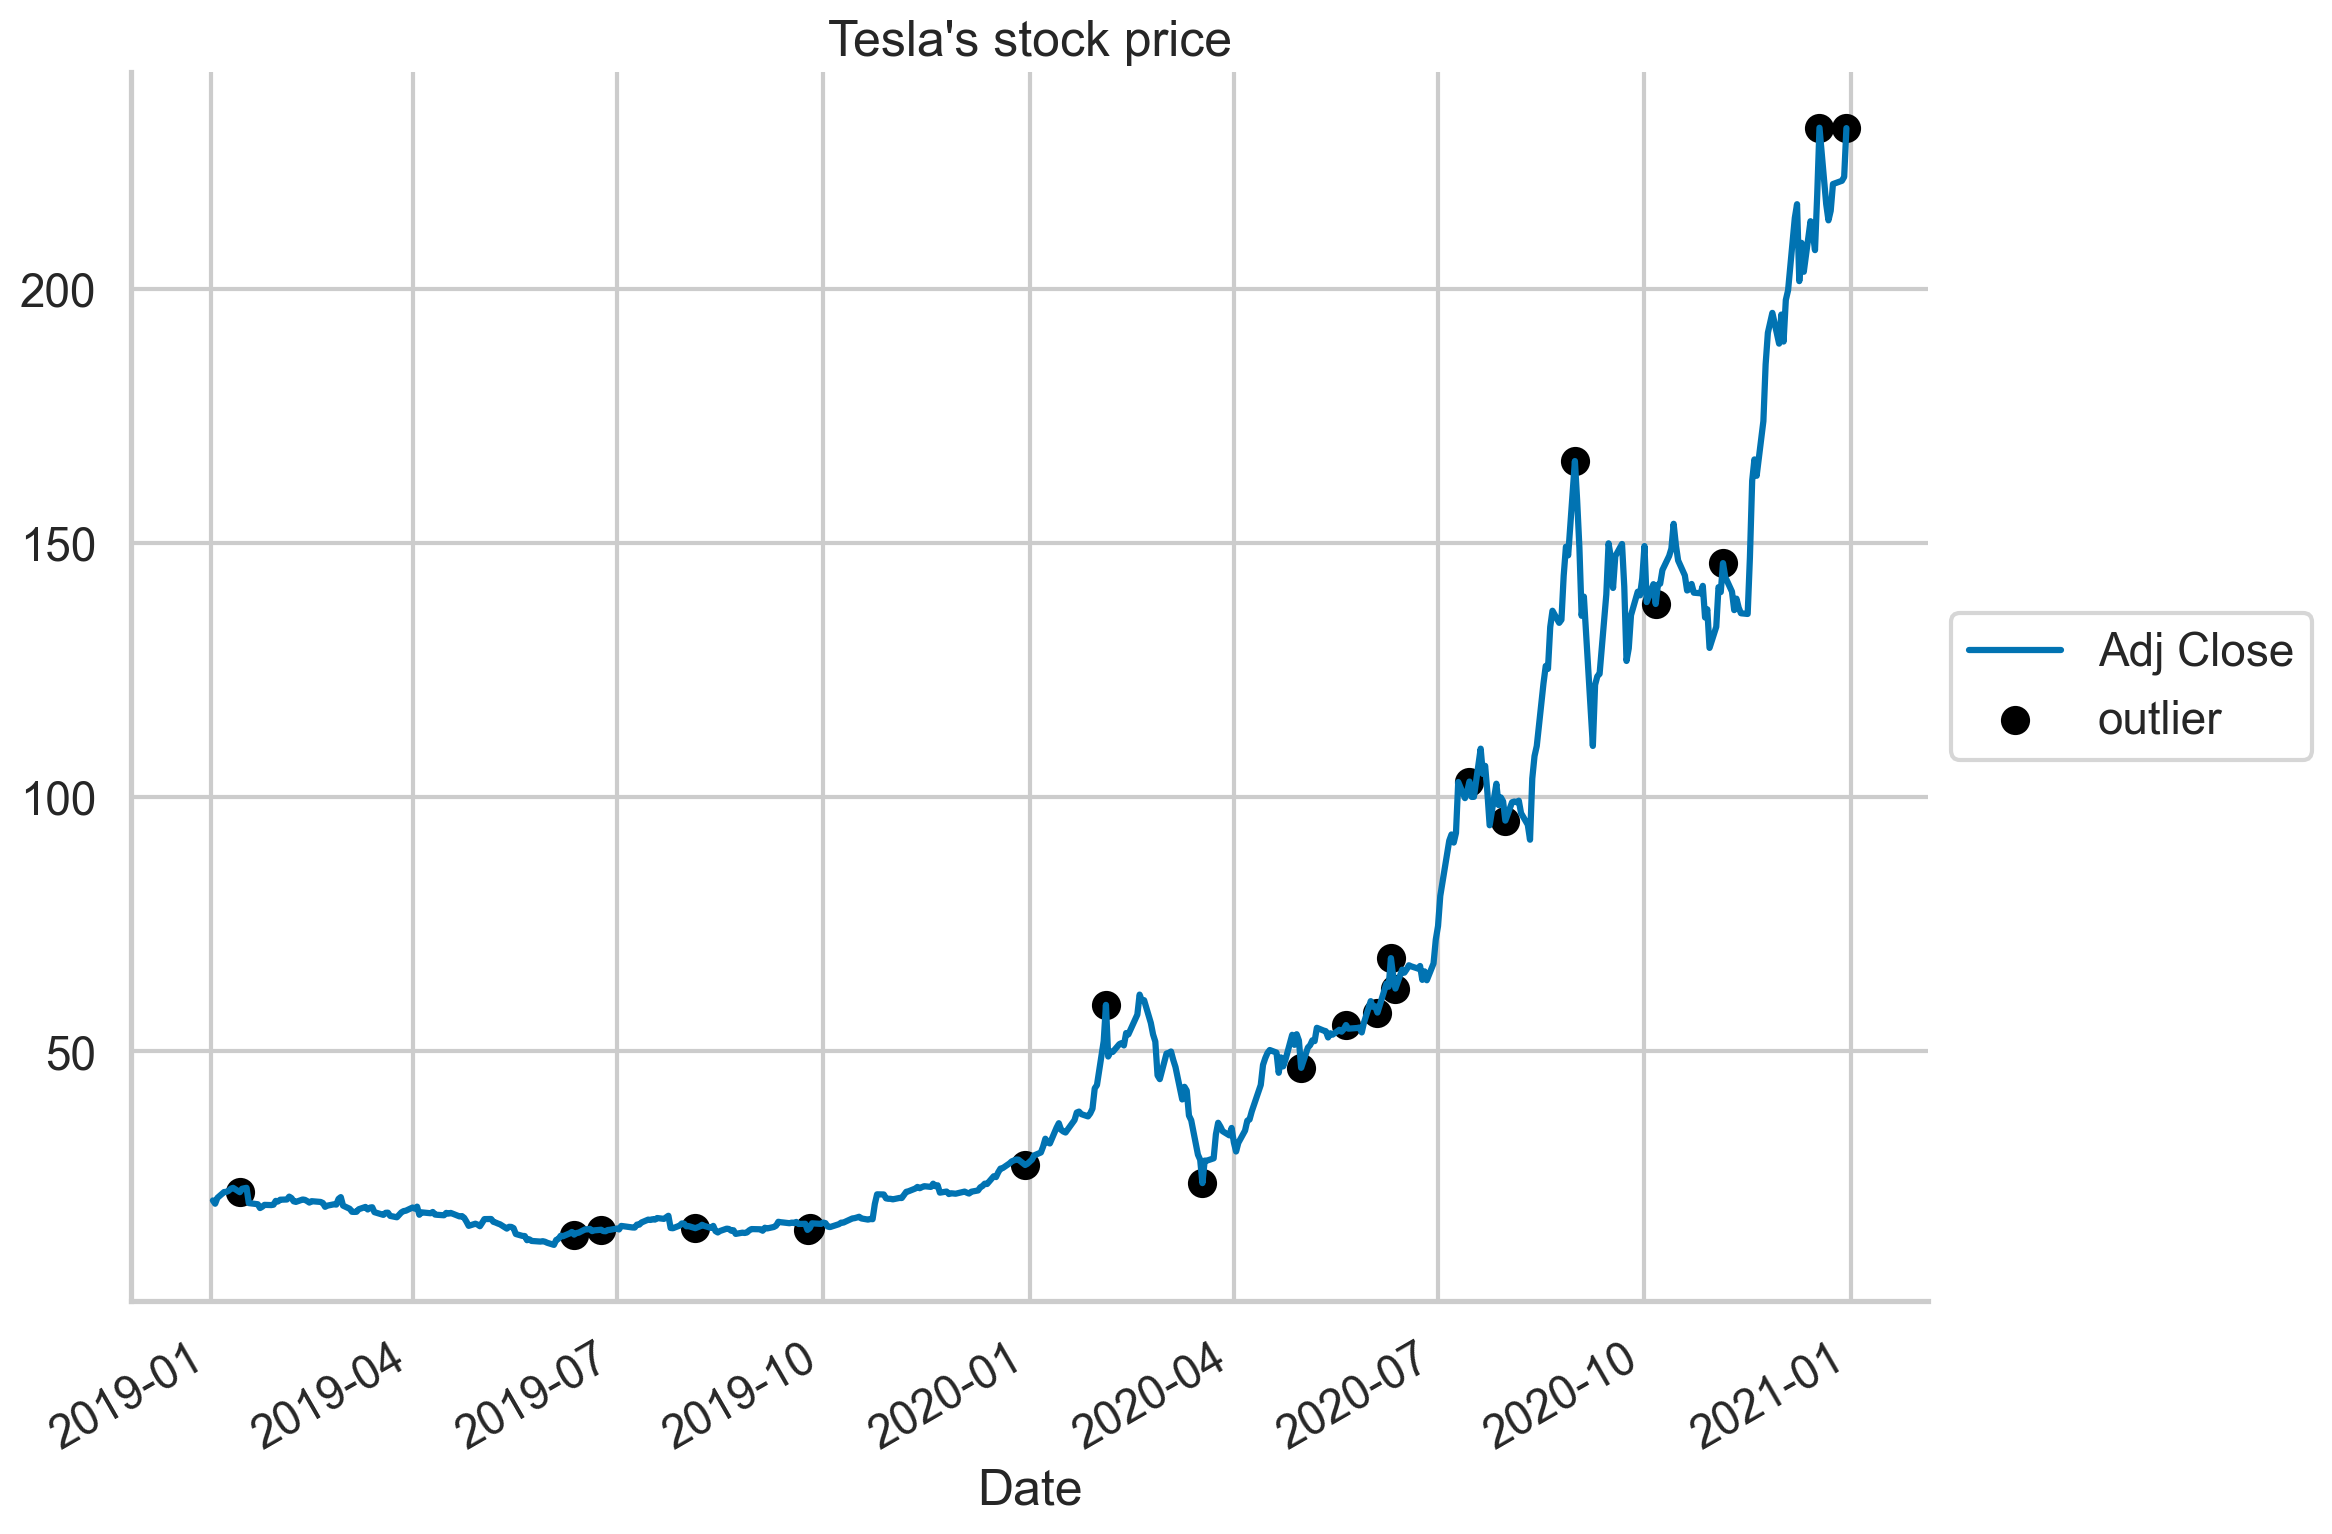

In [16]:
fig, ax = plt.subplots()

df[["Adj Close"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "Adj Close"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock price")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_2", dpi=200)

2020년 9월의 피크값이 이상치로 나타나지 않은 이유는 해당 값의 앞 뒤 5개의 값들이 이미 높은 값들이라서 그렇다.

In [17]:
df = yf.download("TSLA", 
                 start="2019-08-01", 
                 end="2019-10-30",
                 progress=False)
df["rtn"] = df["Adj Close"].pct_change()

In [18]:
hampel_detector = HampelFilter(window_length=10, 
                               return_bool=True)
df["outlier"] = hampel_detector.fit_transform(df["Adj Close"])
df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-08-01  16.176666  16.300667  15.451333  15.590000  15.590000  123892500   
2019-08-02  15.423333  15.751333  15.282000  15.622667  15.622667   92047500   
2019-08-05  15.306667  15.424667  15.052000  15.221333  15.221333  105424500   
2019-08-06  15.458667  15.500000  15.050000  15.383333  15.383333   83463000   
2019-08-07  15.100000  15.571333  15.053333  15.561333  15.561333   71647500   

                 rtn  outlier  
Date                           
2019-08-01       NaN    False  
2019-08-02  0.002095    False  
2019-08-05 -0.025689    False  
2019-08-06  0.010643    False  
2019-08-07  0.011571    False

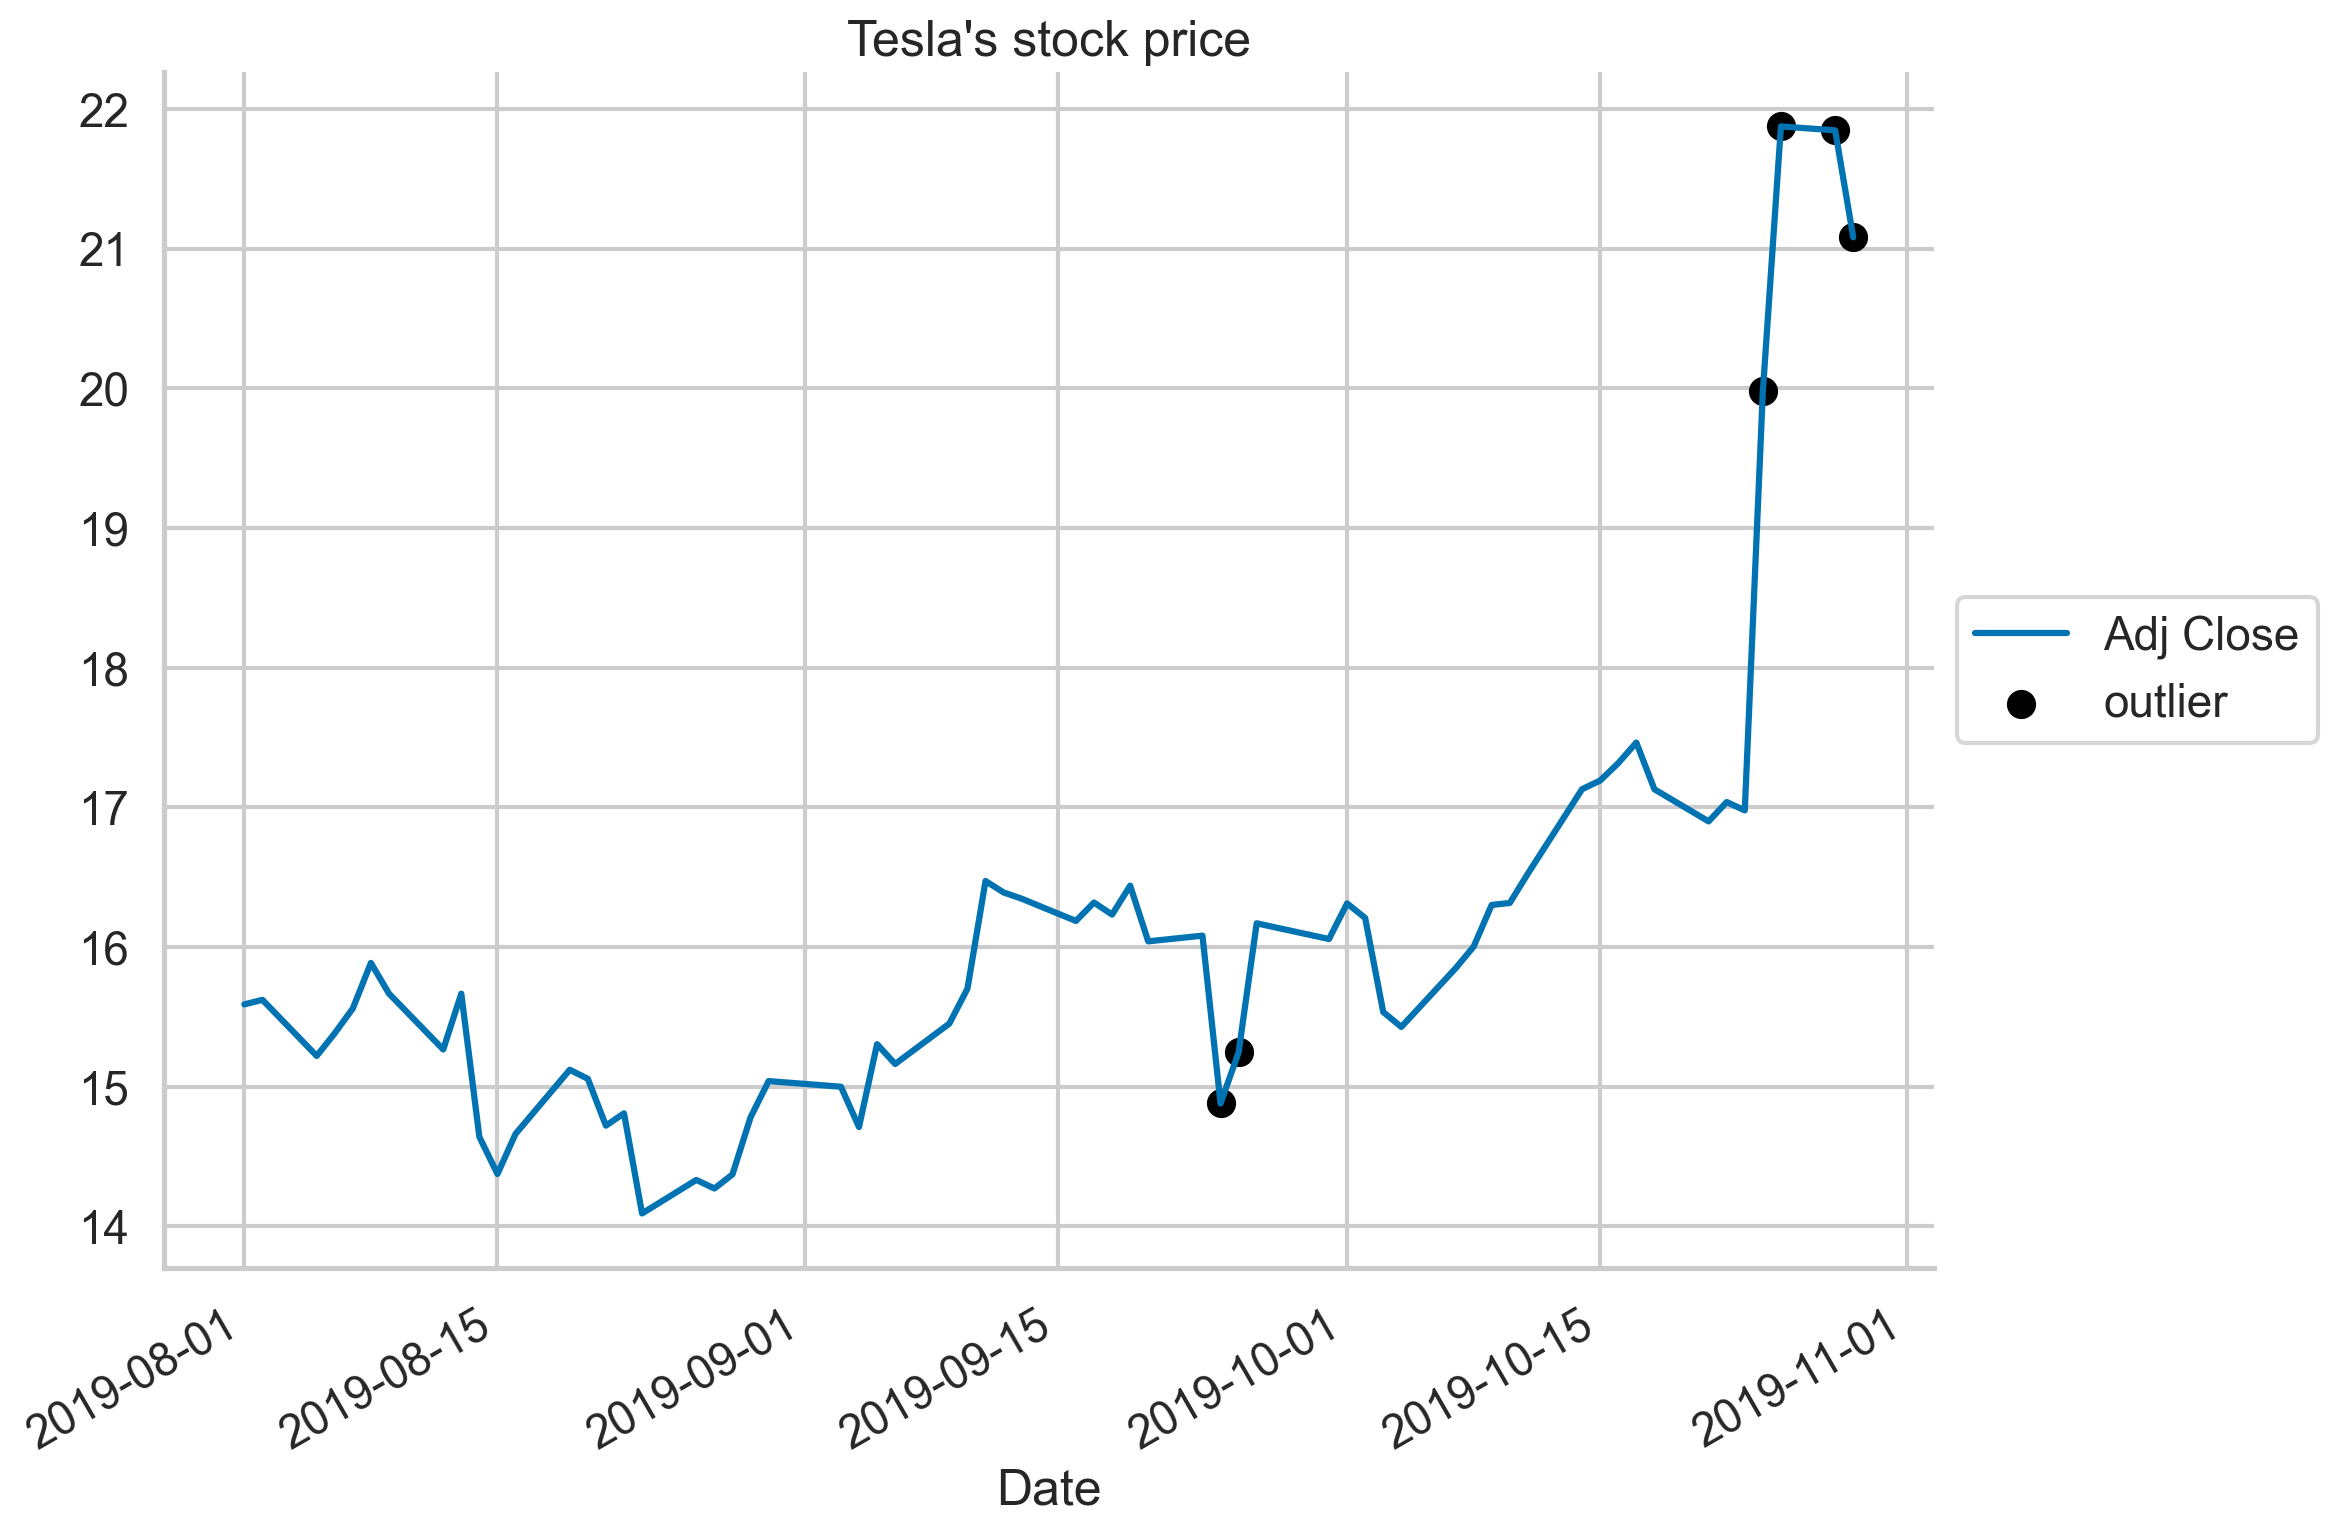

In [19]:
fig, ax = plt.subplots()

df[["Adj Close"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "Adj Close"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock price")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_2", dpi=200)

### 테슬라의 수익률 중에서 이상치를 구해본다.


In [20]:
df["outlier_rtn"] = hampel_detector.fit_transform(df["rtn"])
df.head()

C:\Users\syahn\.conda\envs\cookbook3.8_2\lib\site-packages\sktime\transformations\series\outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-08-01  16.176666  16.300667  15.451333  15.590000  15.590000  123892500   
2019-08-02  15.423333  15.751333  15.282000  15.622667  15.622667   92047500   
2019-08-05  15.306667  15.424667  15.052000  15.221333  15.221333  105424500   
2019-08-06  15.458667  15.500000  15.050000  15.383333  15.383333   83463000   
2019-08-07  15.100000  15.571333  15.053333  15.561333  15.561333   71647500   

                 rtn  outlier  outlier_rtn  
Date                                        
2019-08-01       NaN    False         True  
2019-08-02  0.002095    False        False  
2019-08-05 -0.025689    False        False  
2019-08-06  0.010643    False        False  
2019-08-07  0.011571    False        False

테슬라의 일일 수익률 그래프를 그리고 이상치를 표시한다.

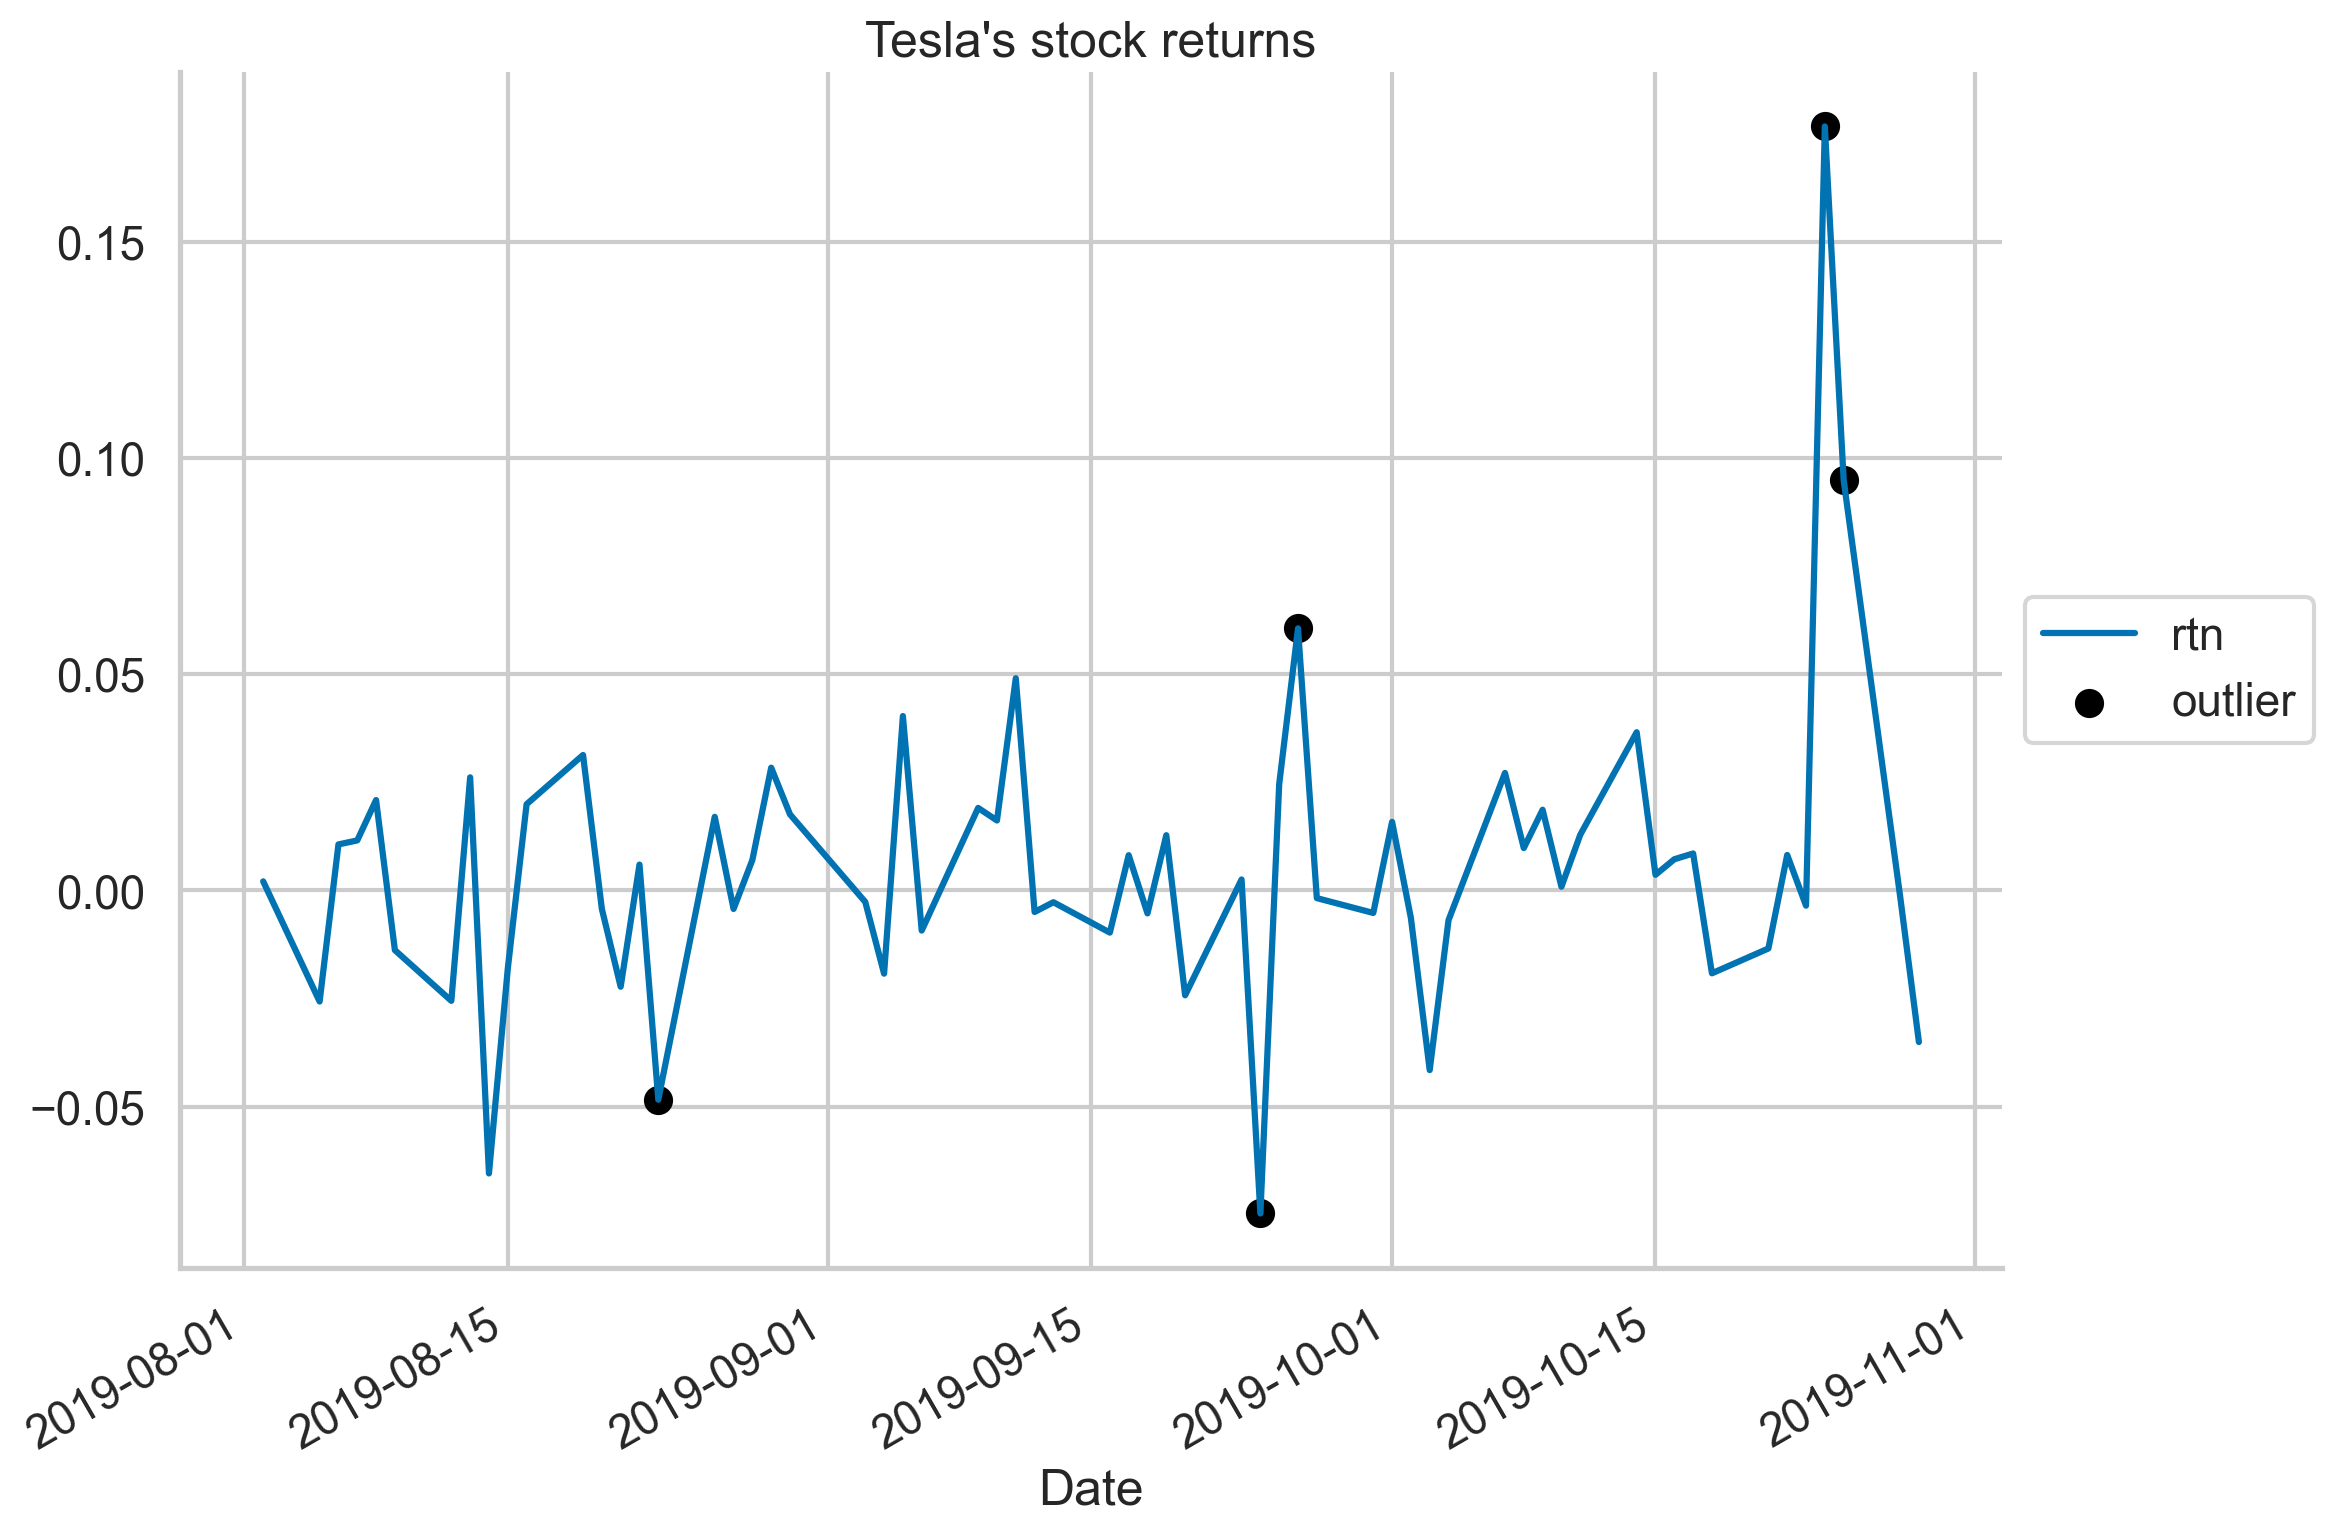

In [21]:
fig, ax = plt.subplots()

df[["rtn"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier_rtn"]].index, 
           df.loc[df["outlier_rtn"], "rtn"], 
           color="black", label="outlier")
ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_3", dpi=200)

주가로도 이상치이고 수익률로도 이상치 날을 구해보면 1개가 나온다.

In [22]:
df.query("outlier == True and outlier_rtn == True").round(2)

Open   High    Low  Close  Adj Close     Volume   rtn  outlier  \
Date                                                                          
2019-09-24  16.10  16.13  14.84  14.88      14.88  193372500 -0.07     True   
2019-10-24  19.89  20.33  19.28  19.98      19.98  445813500  0.18     True   
2019-10-25  19.85  22.00  19.74  21.88      21.88  450091500  0.09     True   

            outlier_rtn  
Date                     
2019-09-24         True  
2019-10-24         True  
2019-10-25         True

## 4.3 Detecting changepoints in time series

변화점(changepoint)는 확률 분포가 바뀌는 지점이다
- 예) 평균이 변화하는 경우

CUSUM 방법을 사용해서 변경점을 찾는다.
- kats 라이브러리의 CUSUMDetector를 사용
- DataFrame 형식을 kats에서 사용하는 형식인 TimeSeriesData로 변환
- CUSUMDetector의 detector 함수를 사용해서 변경점을 찾을 수 있다.

CUSUM 방법
- https://zephyrus1111.tistory.com/400
- 변경점이 없다는 귀무가설 H0와 하나의 변경점이 있다는 가설 H1을 세운다.
- 로그 우도비(Log Likelihood Ratio)의 누적값을 이용해서 맞는 가설을 확인한다.


### Kats 설치 방법

- python 3.8 버전에서 시작
  - `conda create -n cookbook3.8 python=3.8`
  - `conda activate cookbook3.8`
- Kats github에서 최신 상태로 설치
  - `pip install git+https://github.com/facebookresearch/Kats.git#egg=kats`
- 추가 library를 설치
  - yfinance, sktime, pymannkendall, jupyter notebook
  - `pip install jupyter notebook`
  - `pip install yfinance`
  - `pip install sktime`
  - `pip install pymannkendall`
- 오류나는 부분 수정
  - `Lib\site-packages\kats\compat\sklearn.py`
    > 16 line의 "sklearn"을 "scikit-learn"로 변경
  - `Lib\site-packages\statsmodels\tsa\filters\filtertools.py`
    > 18 line의 `scipy.signal.signaltools`를 `scipy.signal._signaltools`로 변경

In [23]:
import yfinance as yf
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

2020년 애플의 주가를 다운로드 한다.

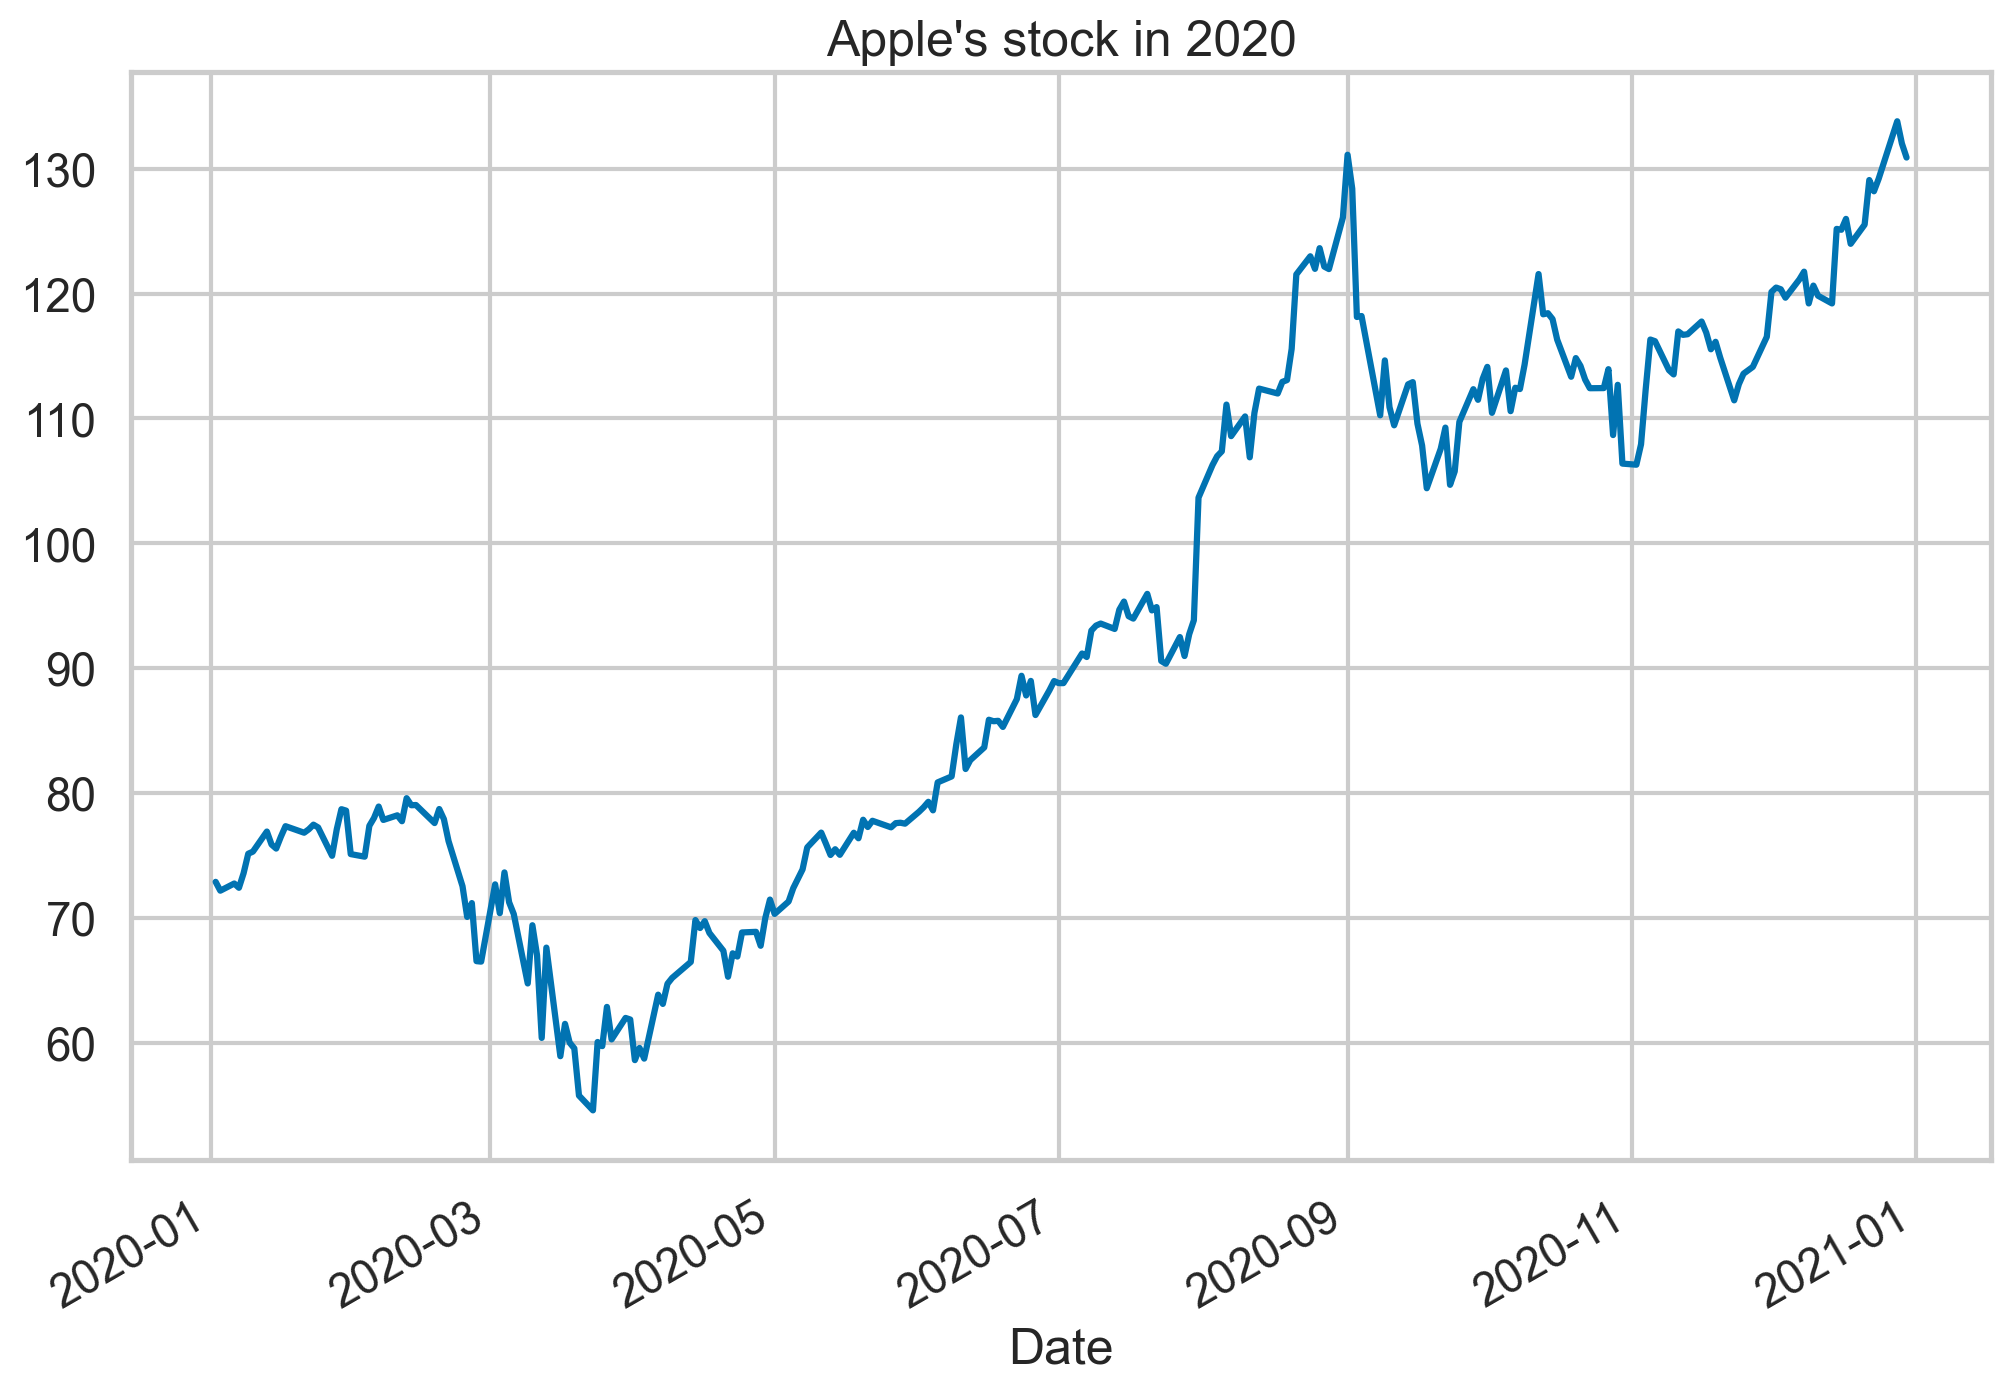

In [24]:
df = yf.download("AAPL", 
                 start="2020-01-01", 
                 end="2020-12-31", 
                 progress=False)
df["Adj Close"].plot(title="Apple's stock in 2020");

조정된 종가만 남기고 인덱스를 리셋한 후 컬럼 이름을 변경한다.

In [25]:
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["time", "price"]

DataFrame 형식을 TimeSeriesData로 변경한다.

In [26]:
tsd = TimeSeriesData(df)

CUSUMDetector의 instance를 만들고 detector 함수로 변경점을 찾는다.

<Axes: >

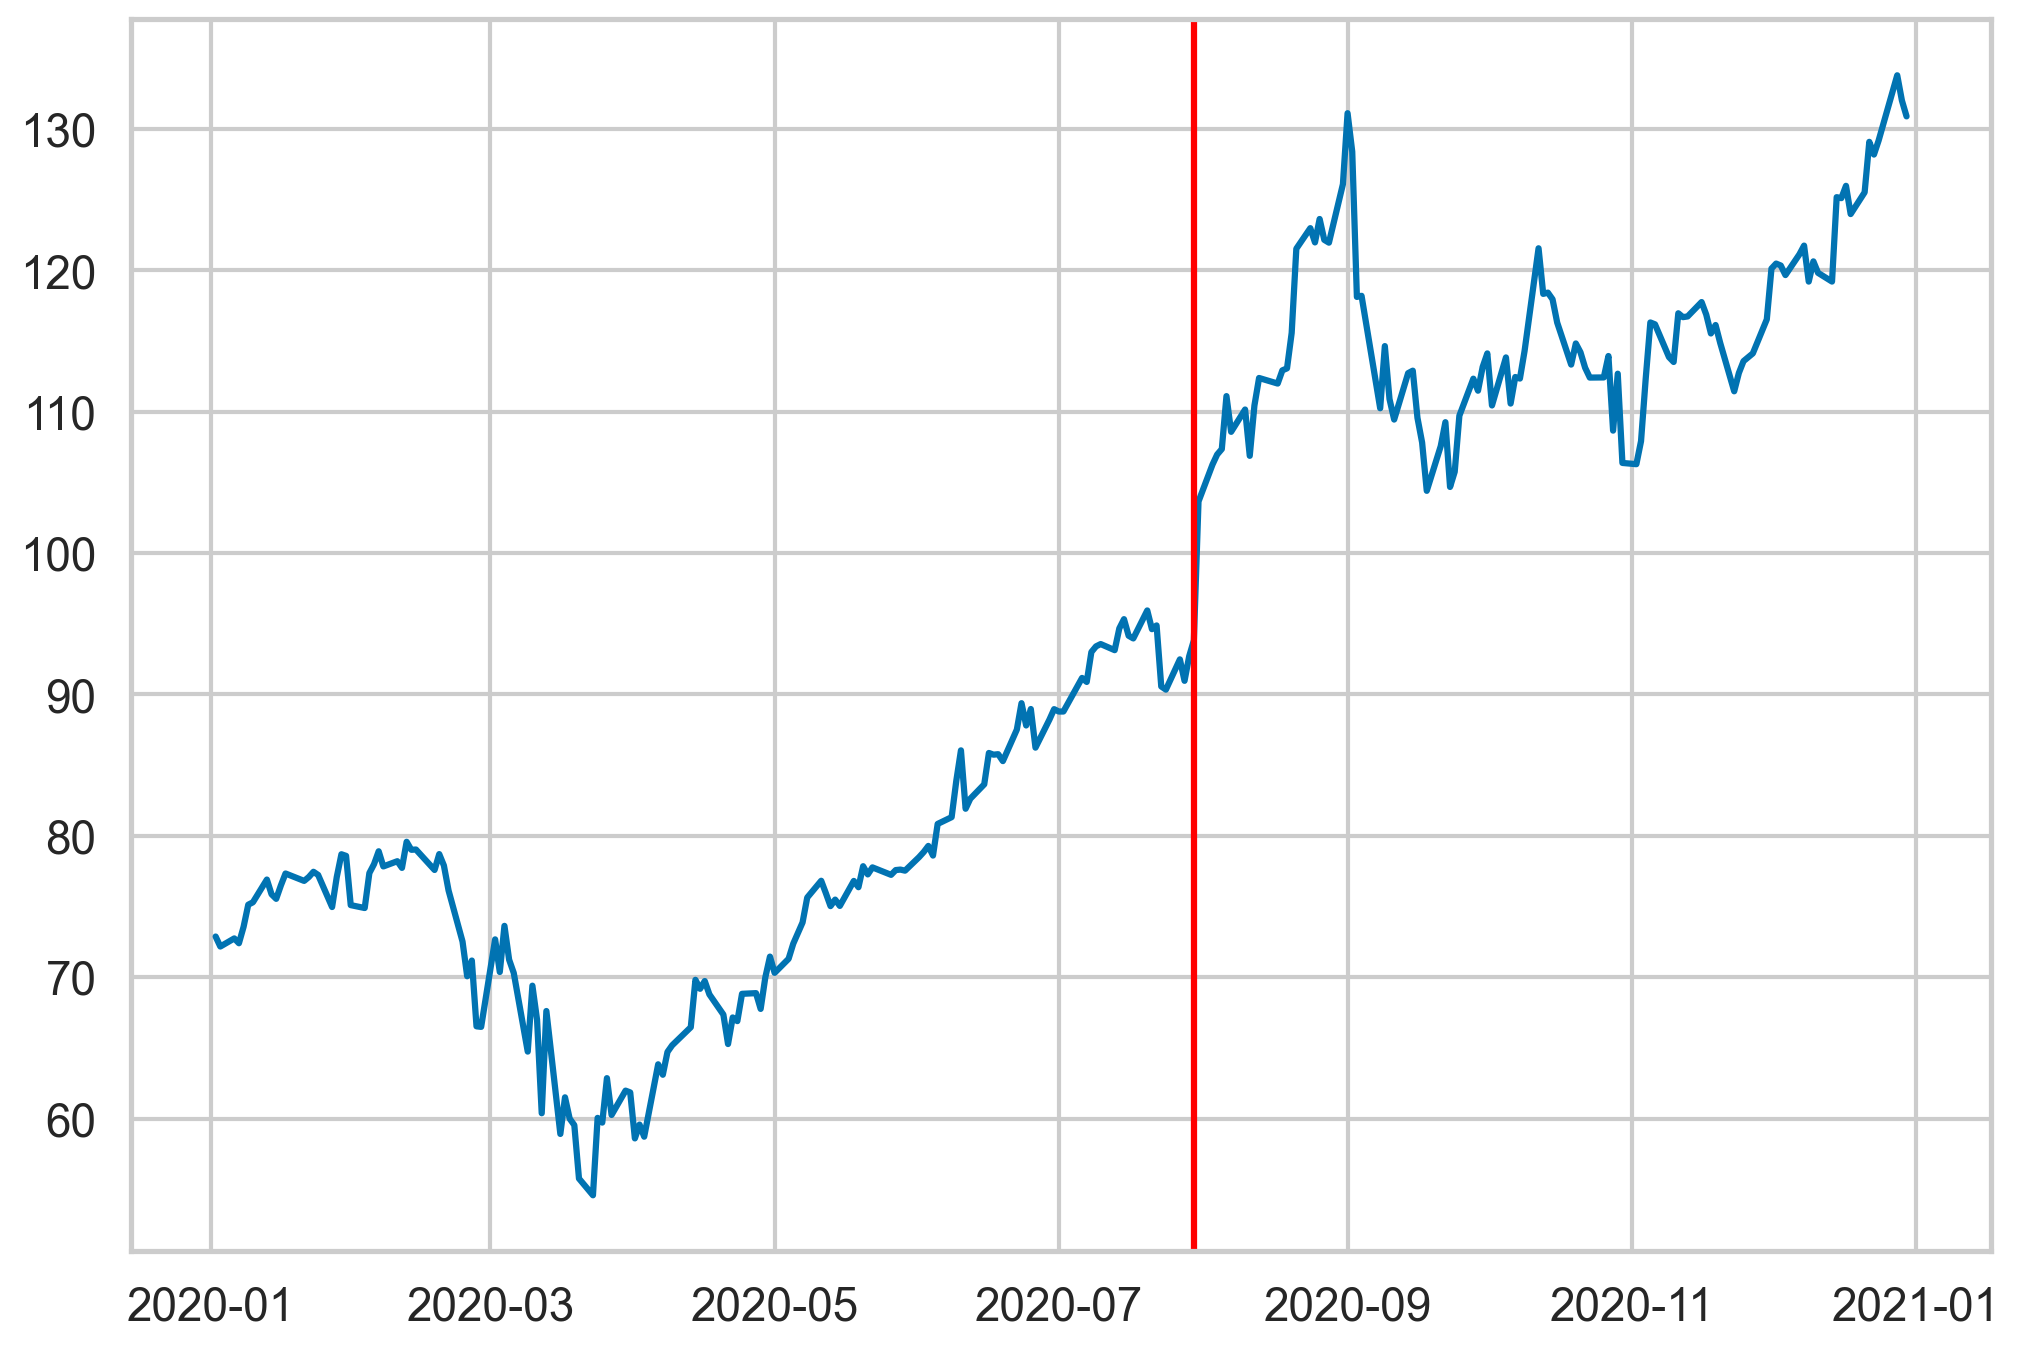

In [27]:
cusum_detector = CUSUMDetector(tsd)
change_points = cusum_detector.detector(
    change_directions=["increase"]
)
cusum_detector.plot(change_points)

변경점의 상세 내용을 확인한다.

In [28]:
#point, meta = change_points[0]
#point
change_points[0]

CUSUMChangePoint(start_time: 2020-07-30 00:00:00, end_time: 2020-07-30 00:00:00, confidence: 1.0, direction: increase, index: 145, delta: 39.51449950014353, regression_detected: True, stable_changepoint: True, mu0: 76.27388347991526, mu1: 115.78838298005878, llr: 451.8957152258325, llr_int: inf, p_value: 0.0, p_value_int: nan)

In [29]:
change_points[0].__dict__

{'_start_time': Timestamp('2020-07-30 00:00:00'),
 '_end_time': Timestamp('2020-07-30 00:00:00'),
 '_confidence': 1.0,
 '_direction': 'increase',
 '_cp_index': 145,
 '_mu0': 76.27388347991526,
 '_mu1': 115.78838298005878,
 '_delta': 39.51449950014353,
 '_llr_int': inf,
 '_llr': 451.8957152258325,
 '_regression_detected': True,
 '_stable_changepoint': True,
 '_p_value': 0.0,
 '_p_value_int': nan}

범위를 지정해서 변경점을 찾을 수 있다.  
주가 데이터의 200번째 ~ 250번째 데이터로 변경점 찾기
- 1년의 데이터는 252개의 데이터가 있다.

<Axes: >

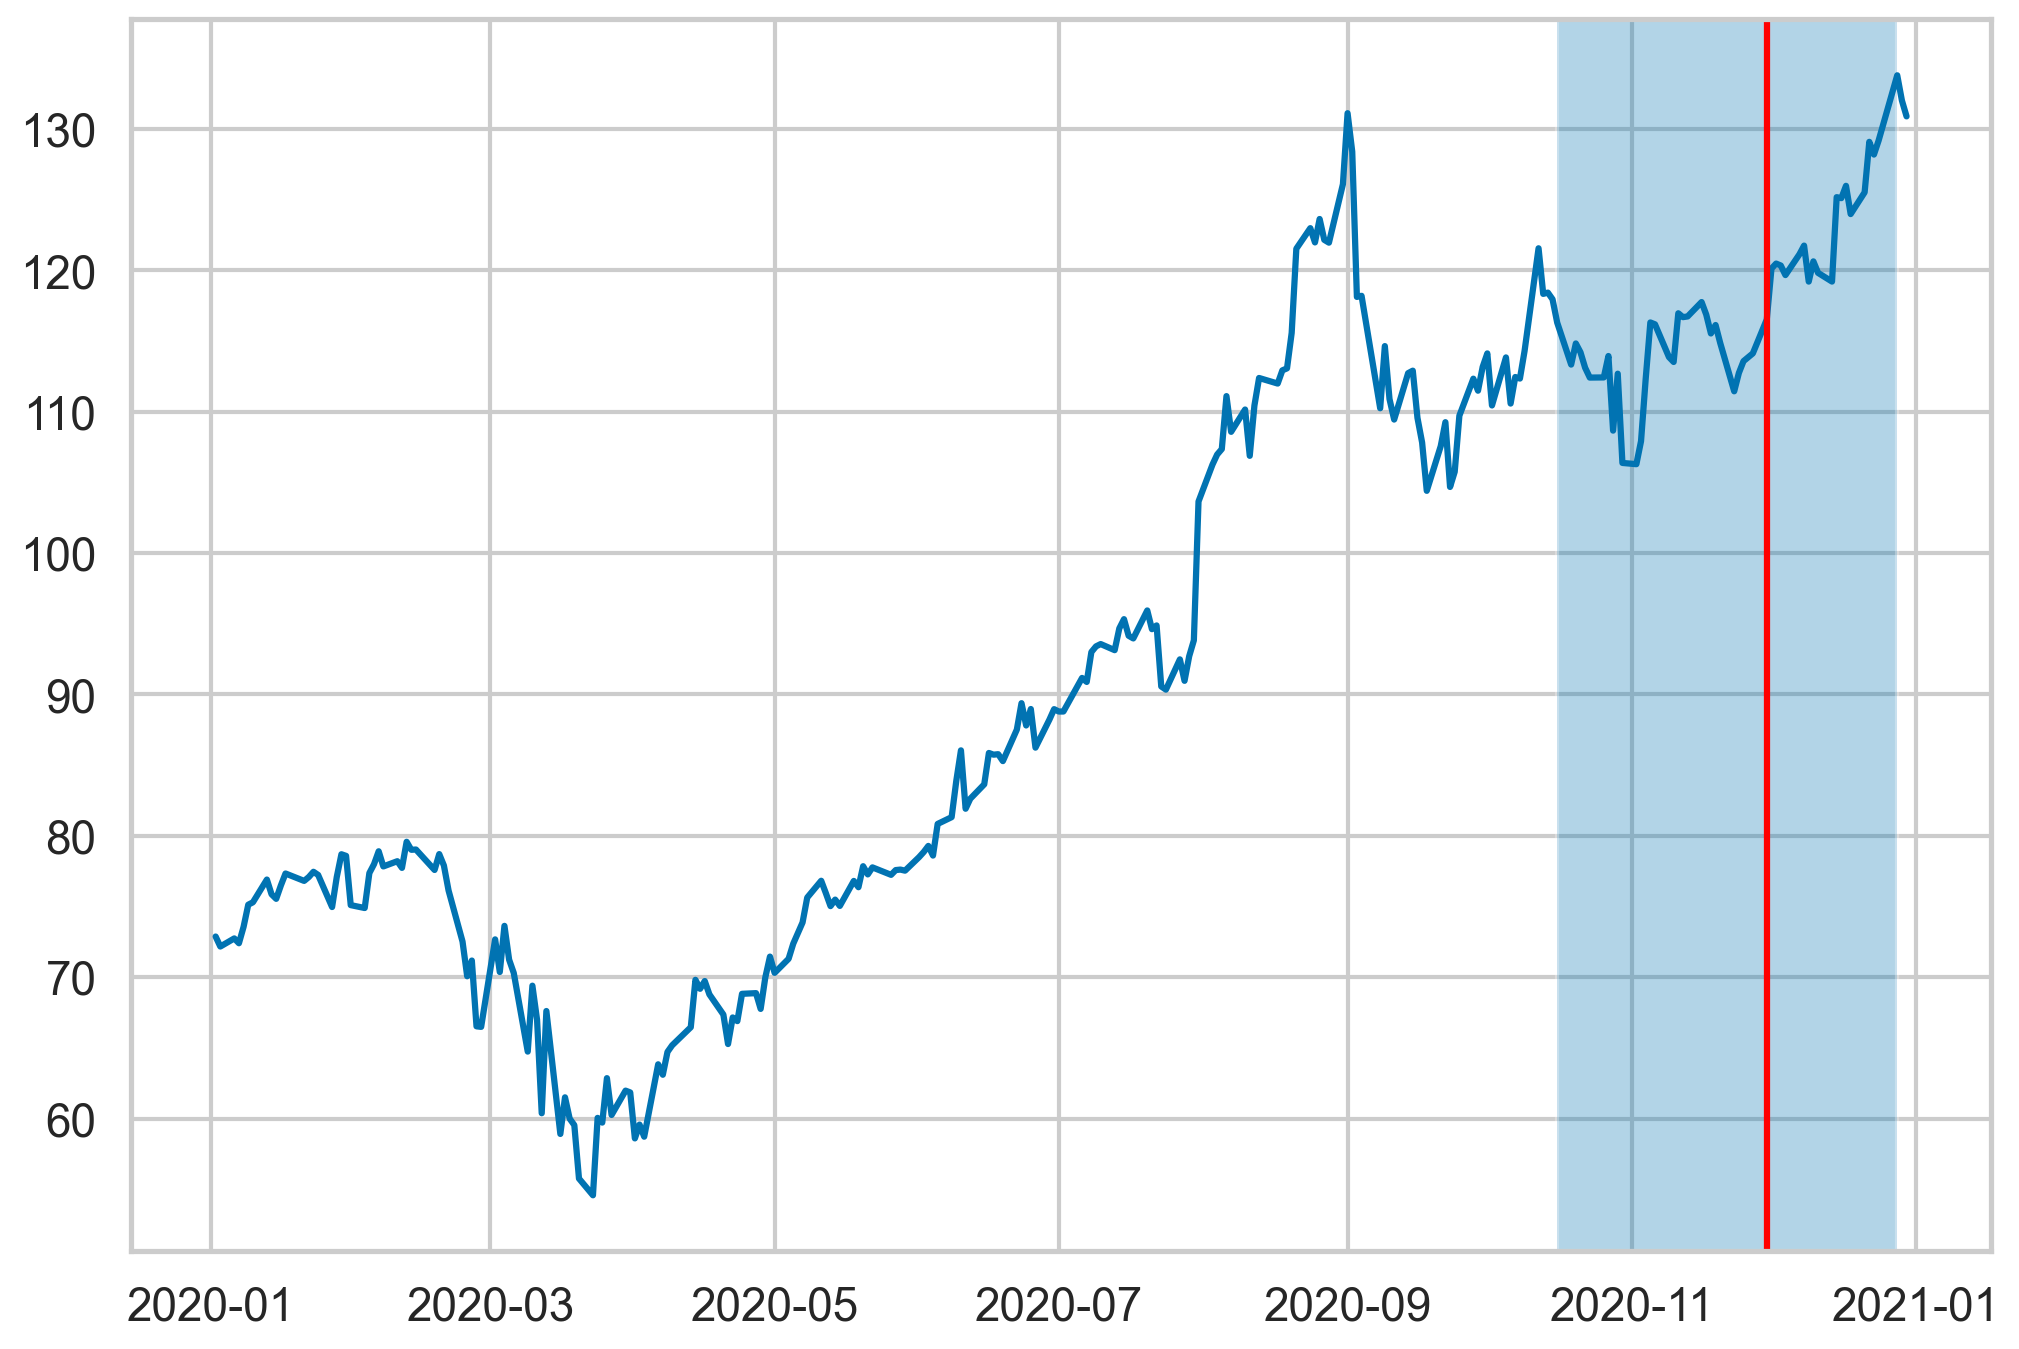

In [30]:
change_points = cusum_detector.detector(change_directions=["increase"], 
                                        interest_window=[200, 250])
cusum_detector.plot(change_points)


kats라이브러리는 변경점을 찾는 방법을 여러개 제공한다.  
RobustStatDetector를 이용해서 변경점을 찾아 본다.

<Axes: >

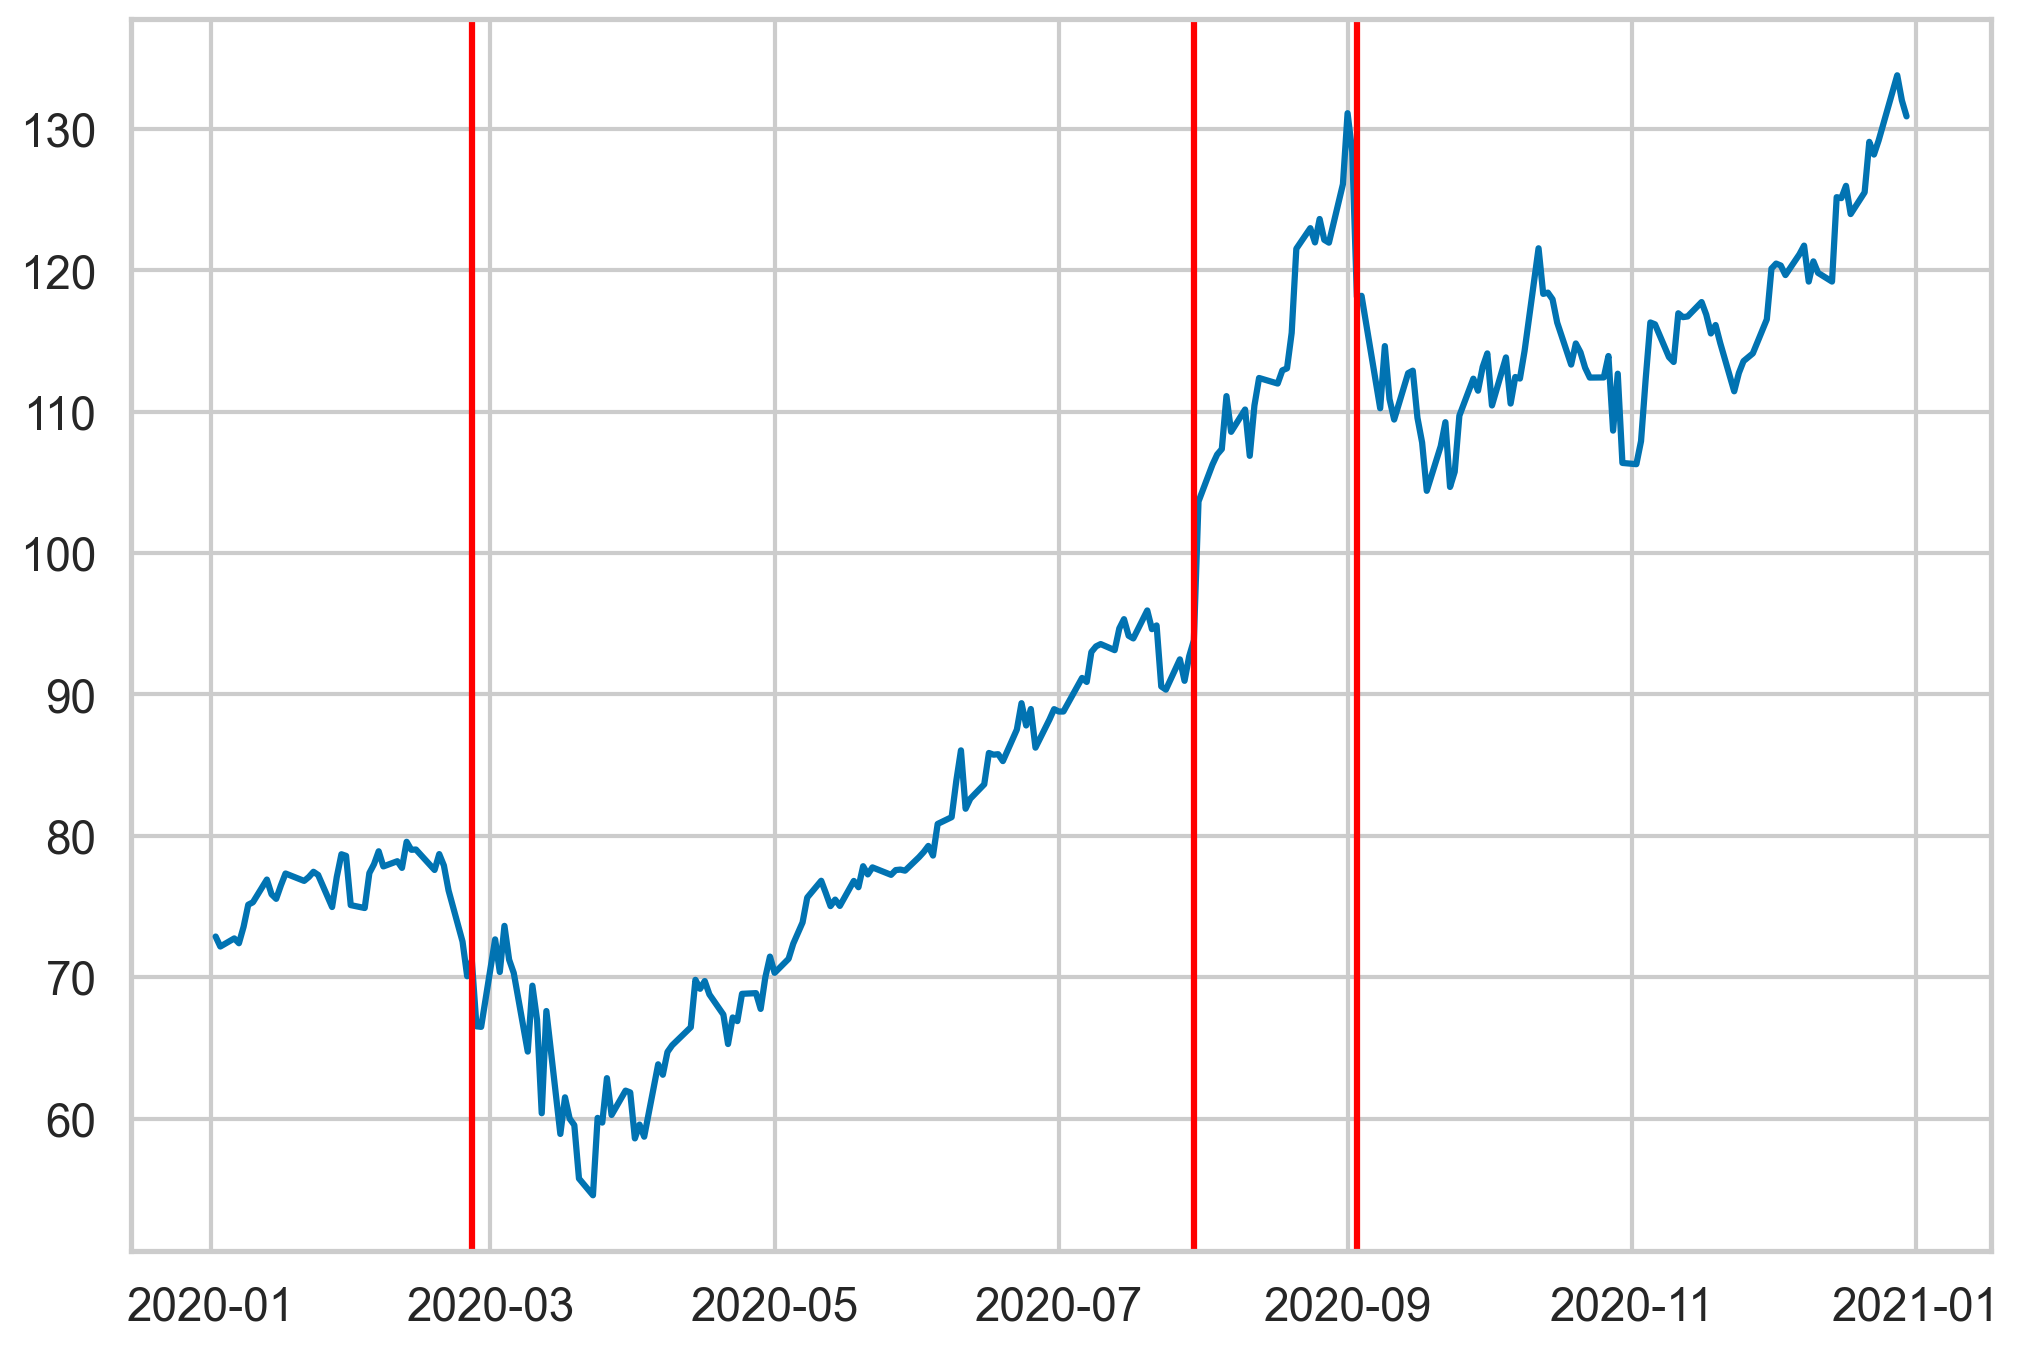

In [31]:
from kats.detectors.robust_stat_detection import RobustStatDetector

robust_detector = RobustStatDetector(tsd)
change_points = robust_detector.detector()
robust_detector.plot(change_points)

<Axes: >

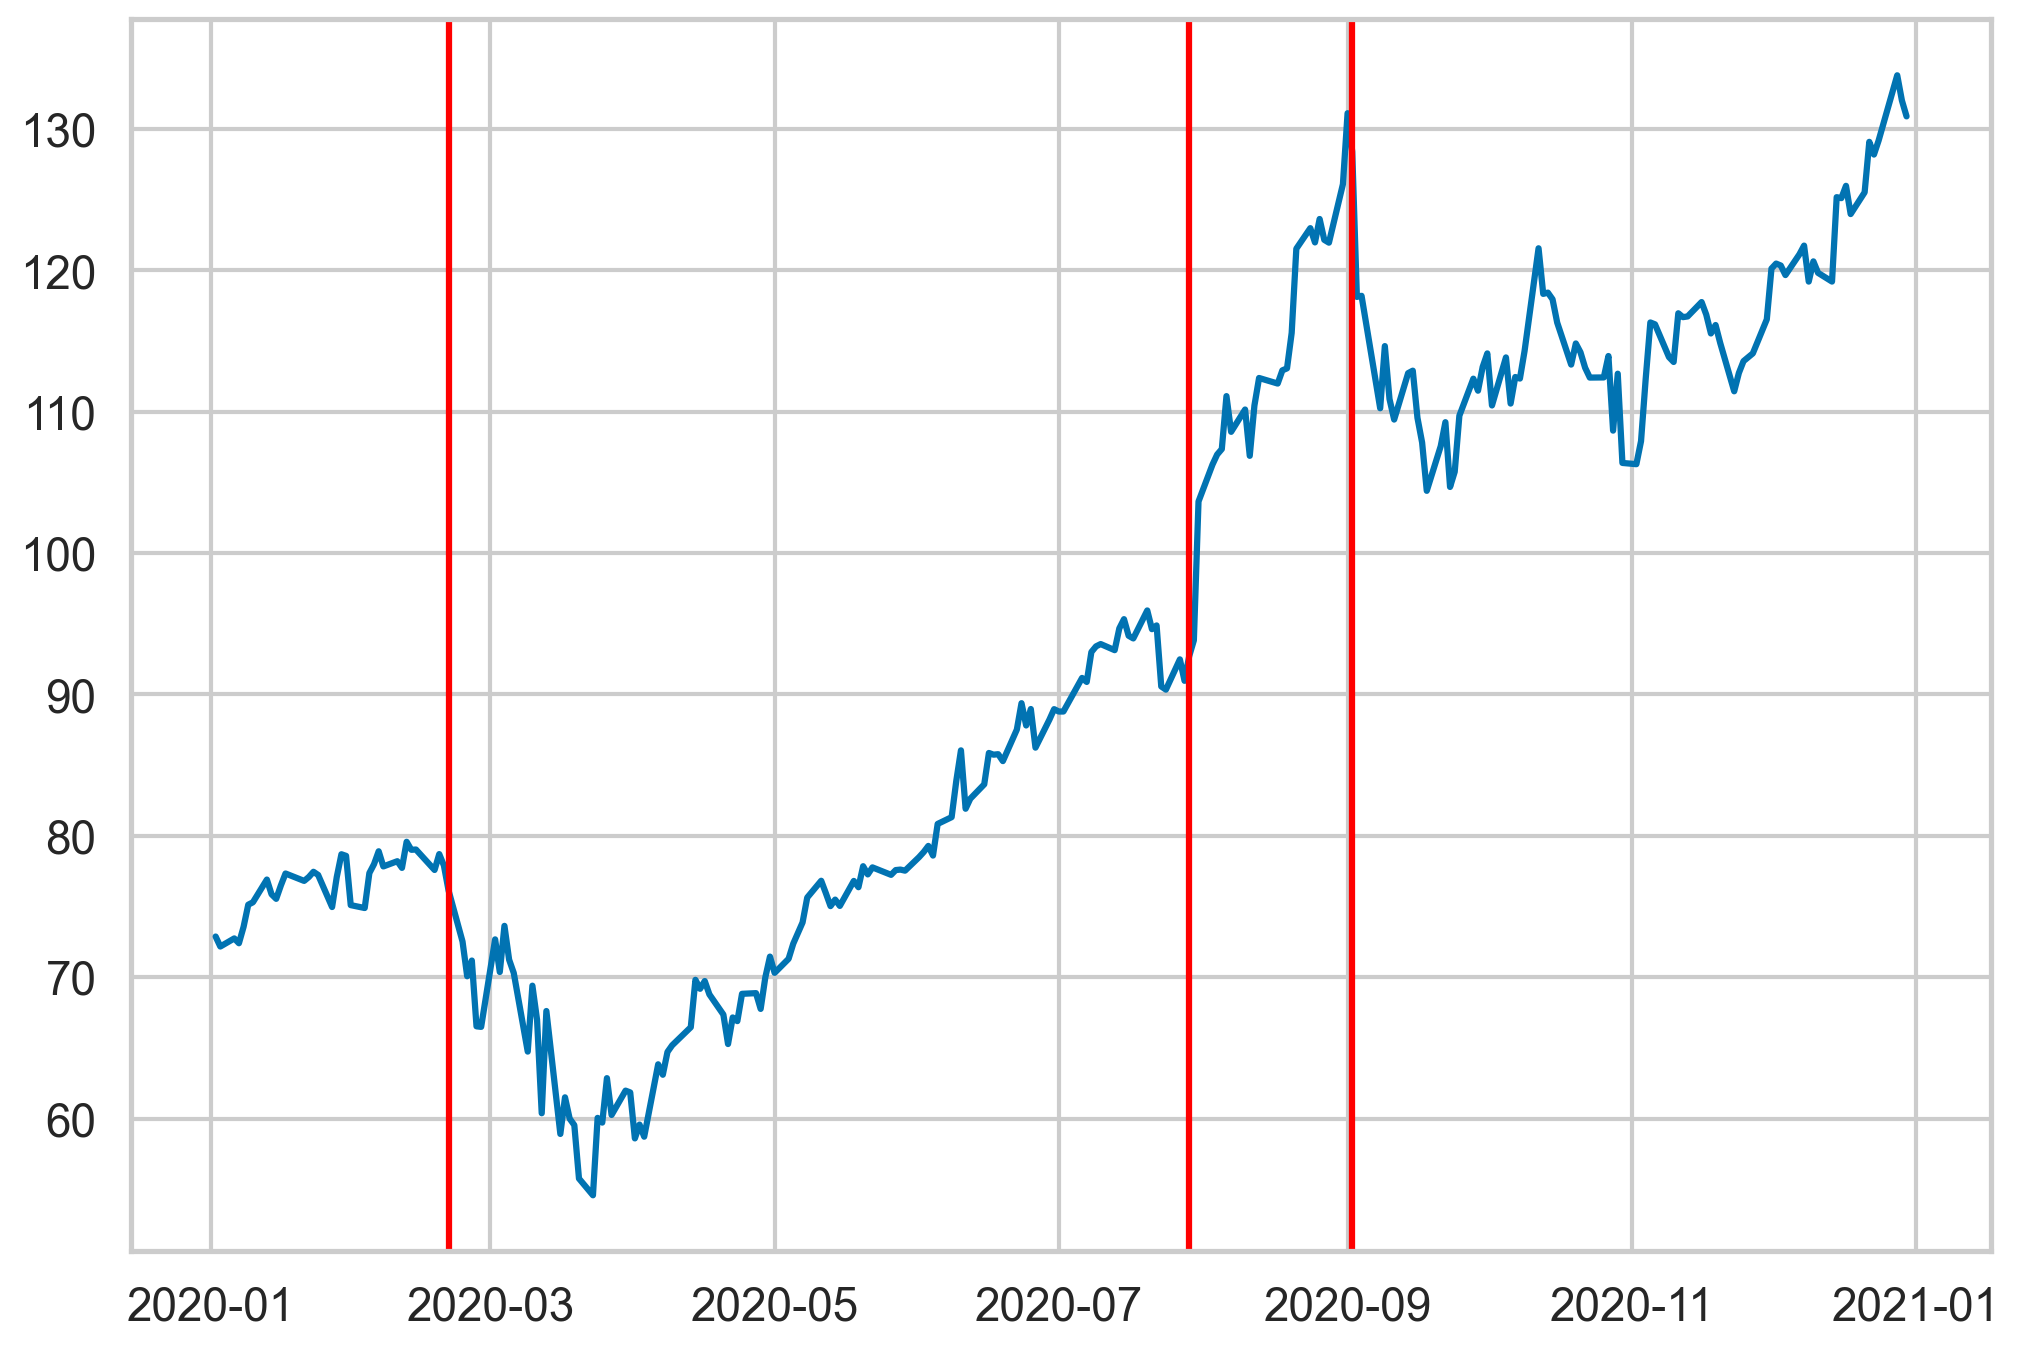

In [32]:
robust_detector = RobustStatDetector(tsd)
changepoints = robust_detector.detector(p_value_cutoff = 0.01, comparison_window=-5)
robust_detector.plot(changepoints)

## 4.4 Detecting trends in time series

추세가 있는지 확인하는 방법

Mann-Kendall(MK) 테스트를 이용해서 추세를 확인해 본다.
- Kendall의 Tau값을 이용해서 추세를 확인
  - -1 이면 완전한 단조 감소
  - 1 이면 완전한 단조 증가
  - 0 이면 추세 없음
- Tau 값이 임계치를 넘어가면 추세가 있는 것으로 판단.

kats 라이브러리의 MKDetector를 이용해서 추세를 찾아 본다.
- TimeSeriesData와 임계치 값을 설정해서 MKDetector instance를 생성
- detector 함수를 이용해서 추세가 시작되는 시점을 찾는다.

In [33]:
import yfinance as yf
from kats.consts import TimeSeriesData
from kats.detectors.trend_mk import MKDetector

2020년 NVIDIA의 주가를 다운로드

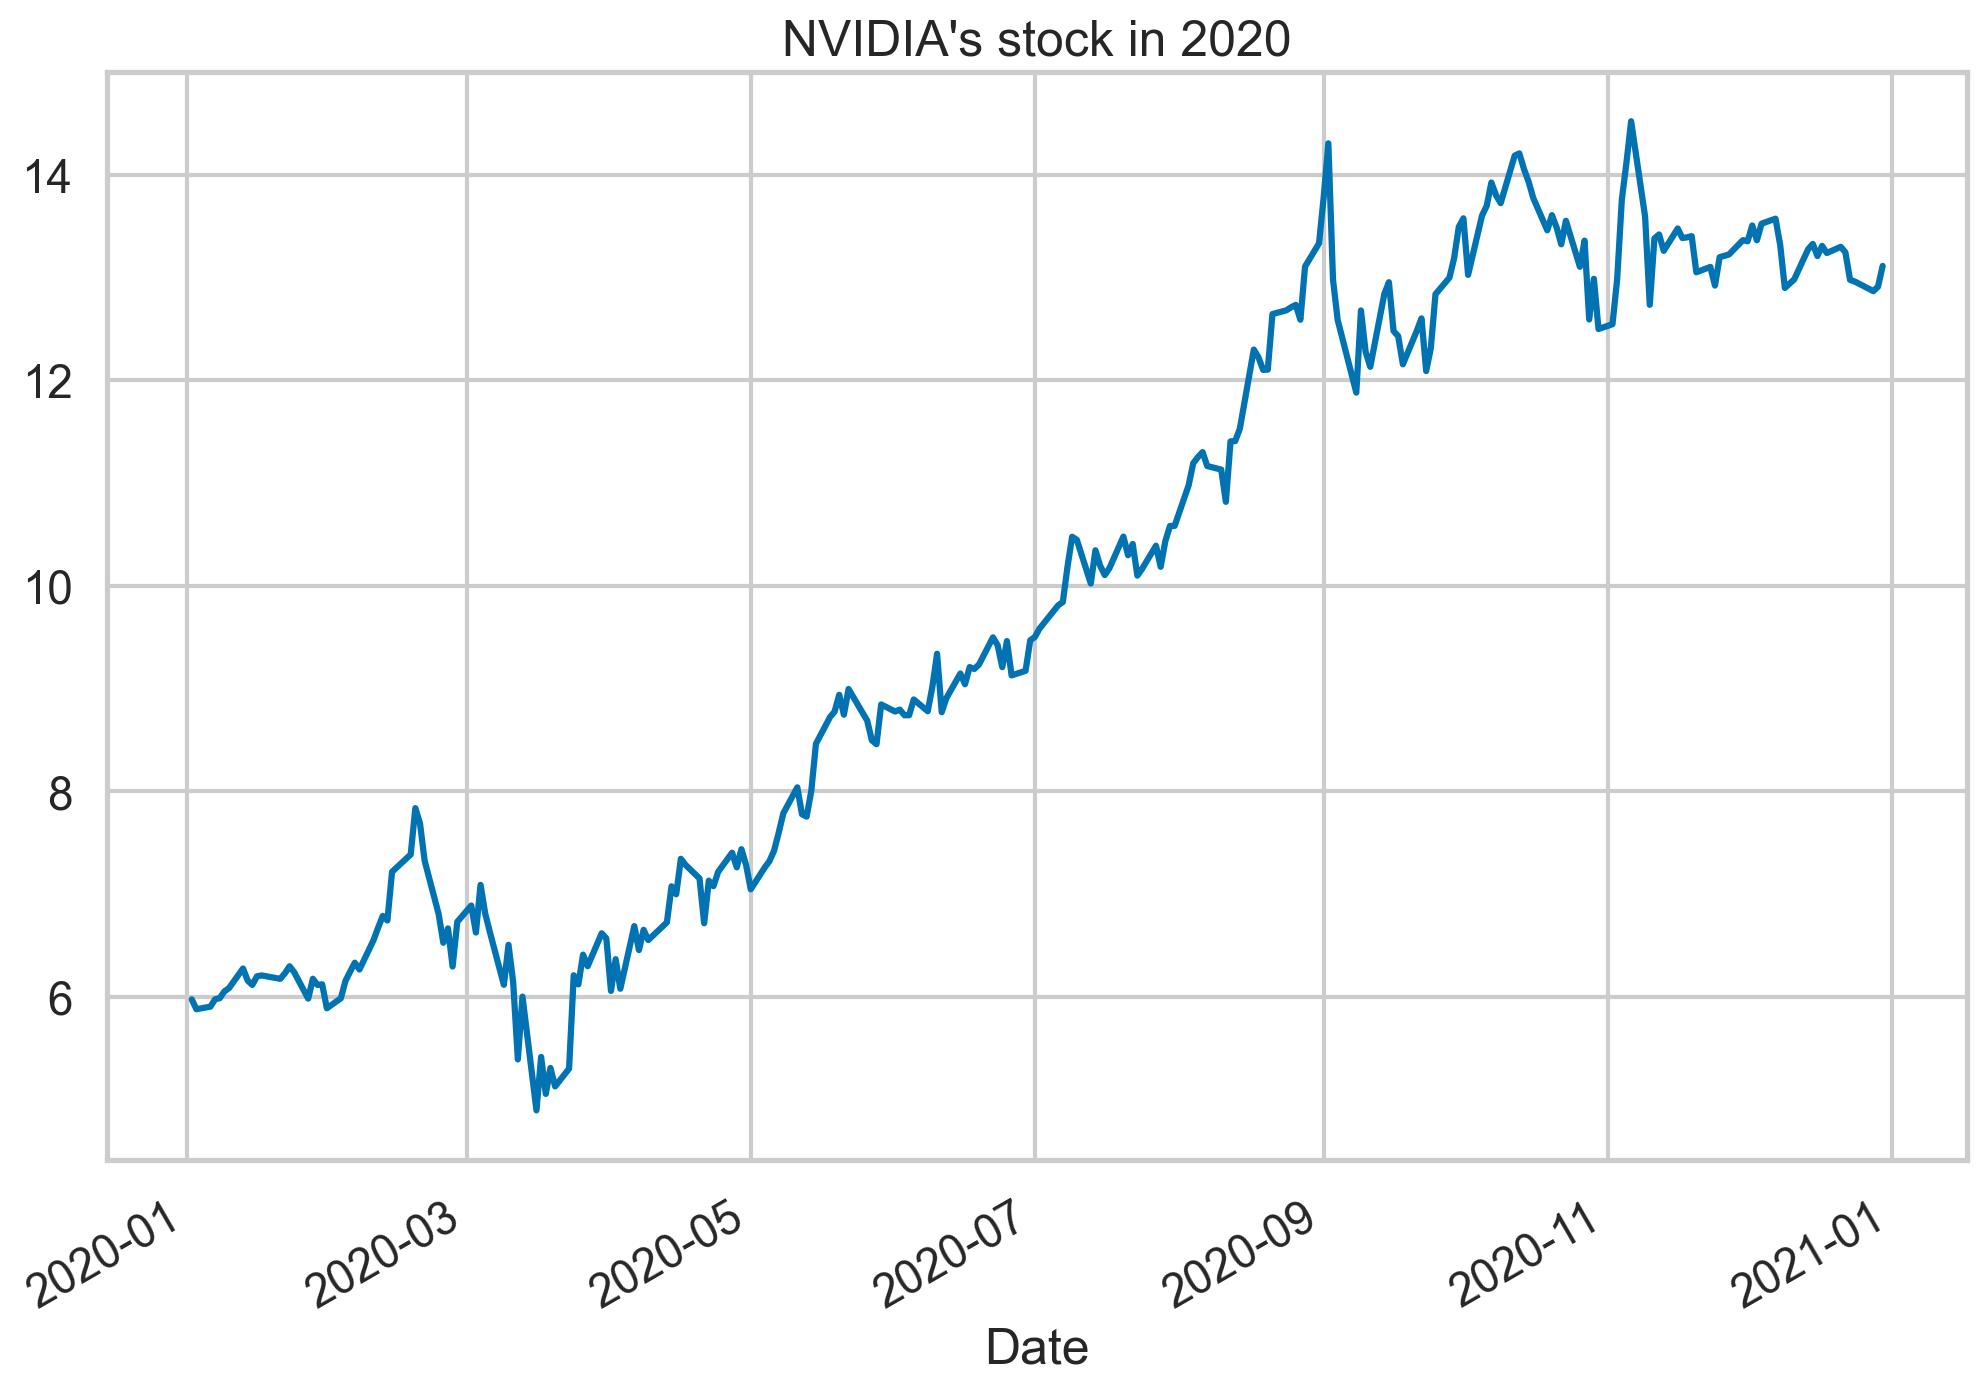

In [34]:
df = yf.download("NVDA", 
                 start="2020-01-01", 
                 end="2020-12-31", 
                 progress=False)
df["Adj Close"].plot(title="NVIDIA's stock in 2020");

조정된 종가만 남기고 인덱스를 리셋한 후 컬럼 이름을 변경한다.

In [35]:
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["time", "price"]

DataFrame 형식을 TimeSeriesData로 변경한다.

In [36]:
tsd = TimeSeriesData(df)

MKDetector의 instance를 만들고 detector 함수로 변경점을 찾는다.

In [37]:
trend_detector = MKDetector(tsd, threshold=0.9)
time_points = trend_detector.detector(
    direction="up", 
    window_size=30
)

C:\Users\syahn\.conda\envs\cookbook3.8_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<Axes: >

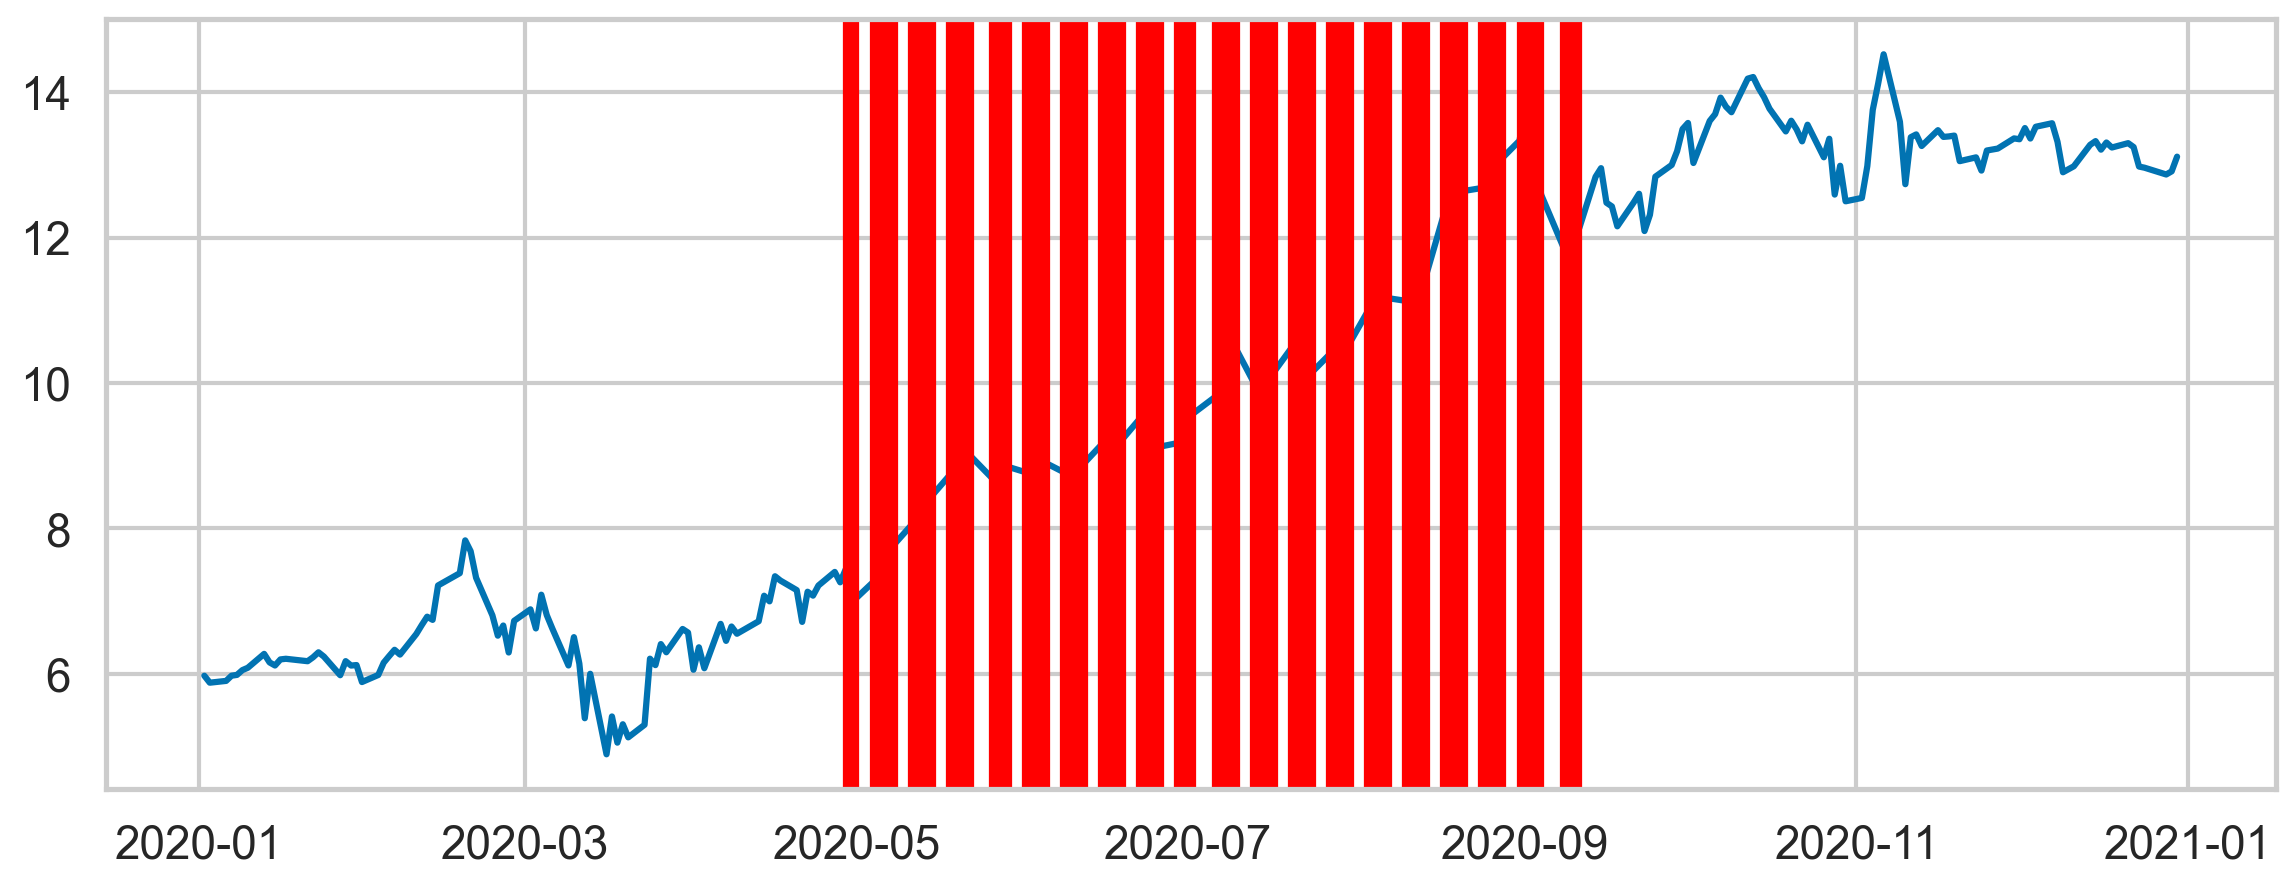

In [38]:
trend_detector.plot(time_points)

변경점의 상세 내용을 확인

In [39]:
len(time_points)

95

In [40]:
#cp, meta = time_points[0]
time_points[0]

MKChangePoint(start_time: 2020-04-29 00:00:00, end_time: 2020-04-29 00:00:00, confidence: 0.999999999998759, detector_type: <class 'kats.detectors.trend_mk.MKDetector'>, is_multivariate: False, trend_direction: increasing Tau: 0.9172413793103448)

In [41]:
time_points[0].__dict__

{'_start_time': Timestamp('2020-04-29 00:00:00'),
 '_end_time': Timestamp('2020-04-29 00:00:00'),
 '_confidence': 0.999999999998759,
 '_detector_type': kats.detectors.trend_mk.MKDetector,
 '_is_multivariate': False,
 '_trend_direction': 'increasing',
 '_Tau': 0.9172413793103448}

## 4.5 Detecting patterns in a time series using the Hurst exponent

시계열의 특정 패턴을 Hurst exponent를 이용해서 확인해 본다.

금융 시장에서 매매 전략은 다음 두가지를 기반으로 한다.
- Momentum: 투자자들은 시장 추세를 따라가려는 경향이 있다.
- Mean-reversion: 주식 수익률과 변동성을 장기 평균으로 수렴하는 경향이 있다.

Hurst exponent를 이용하면 시계열을 다음 3가지 중에 하나로 분류할 수 있다.
- 추세 중
- 평균 수렴 중
- 무작위 이동

Hurst exponent에 대한 설명
- 시계열의 Long-term memory(Long-range dependence)를 측정
- 0.5이면 무작위 이동
- 0.5보다 작으면 평균 회귀 중
- 0.5보다 크면 추세 중으로 판단한다.
- https://en.wikipedia.org/wiki/Hurst_exponent 

In [42]:
import yfinance as yf
import numpy as np
import pandas as pd

2000년부터 2019년까지의 S&P 500 데이터를 가져온다.

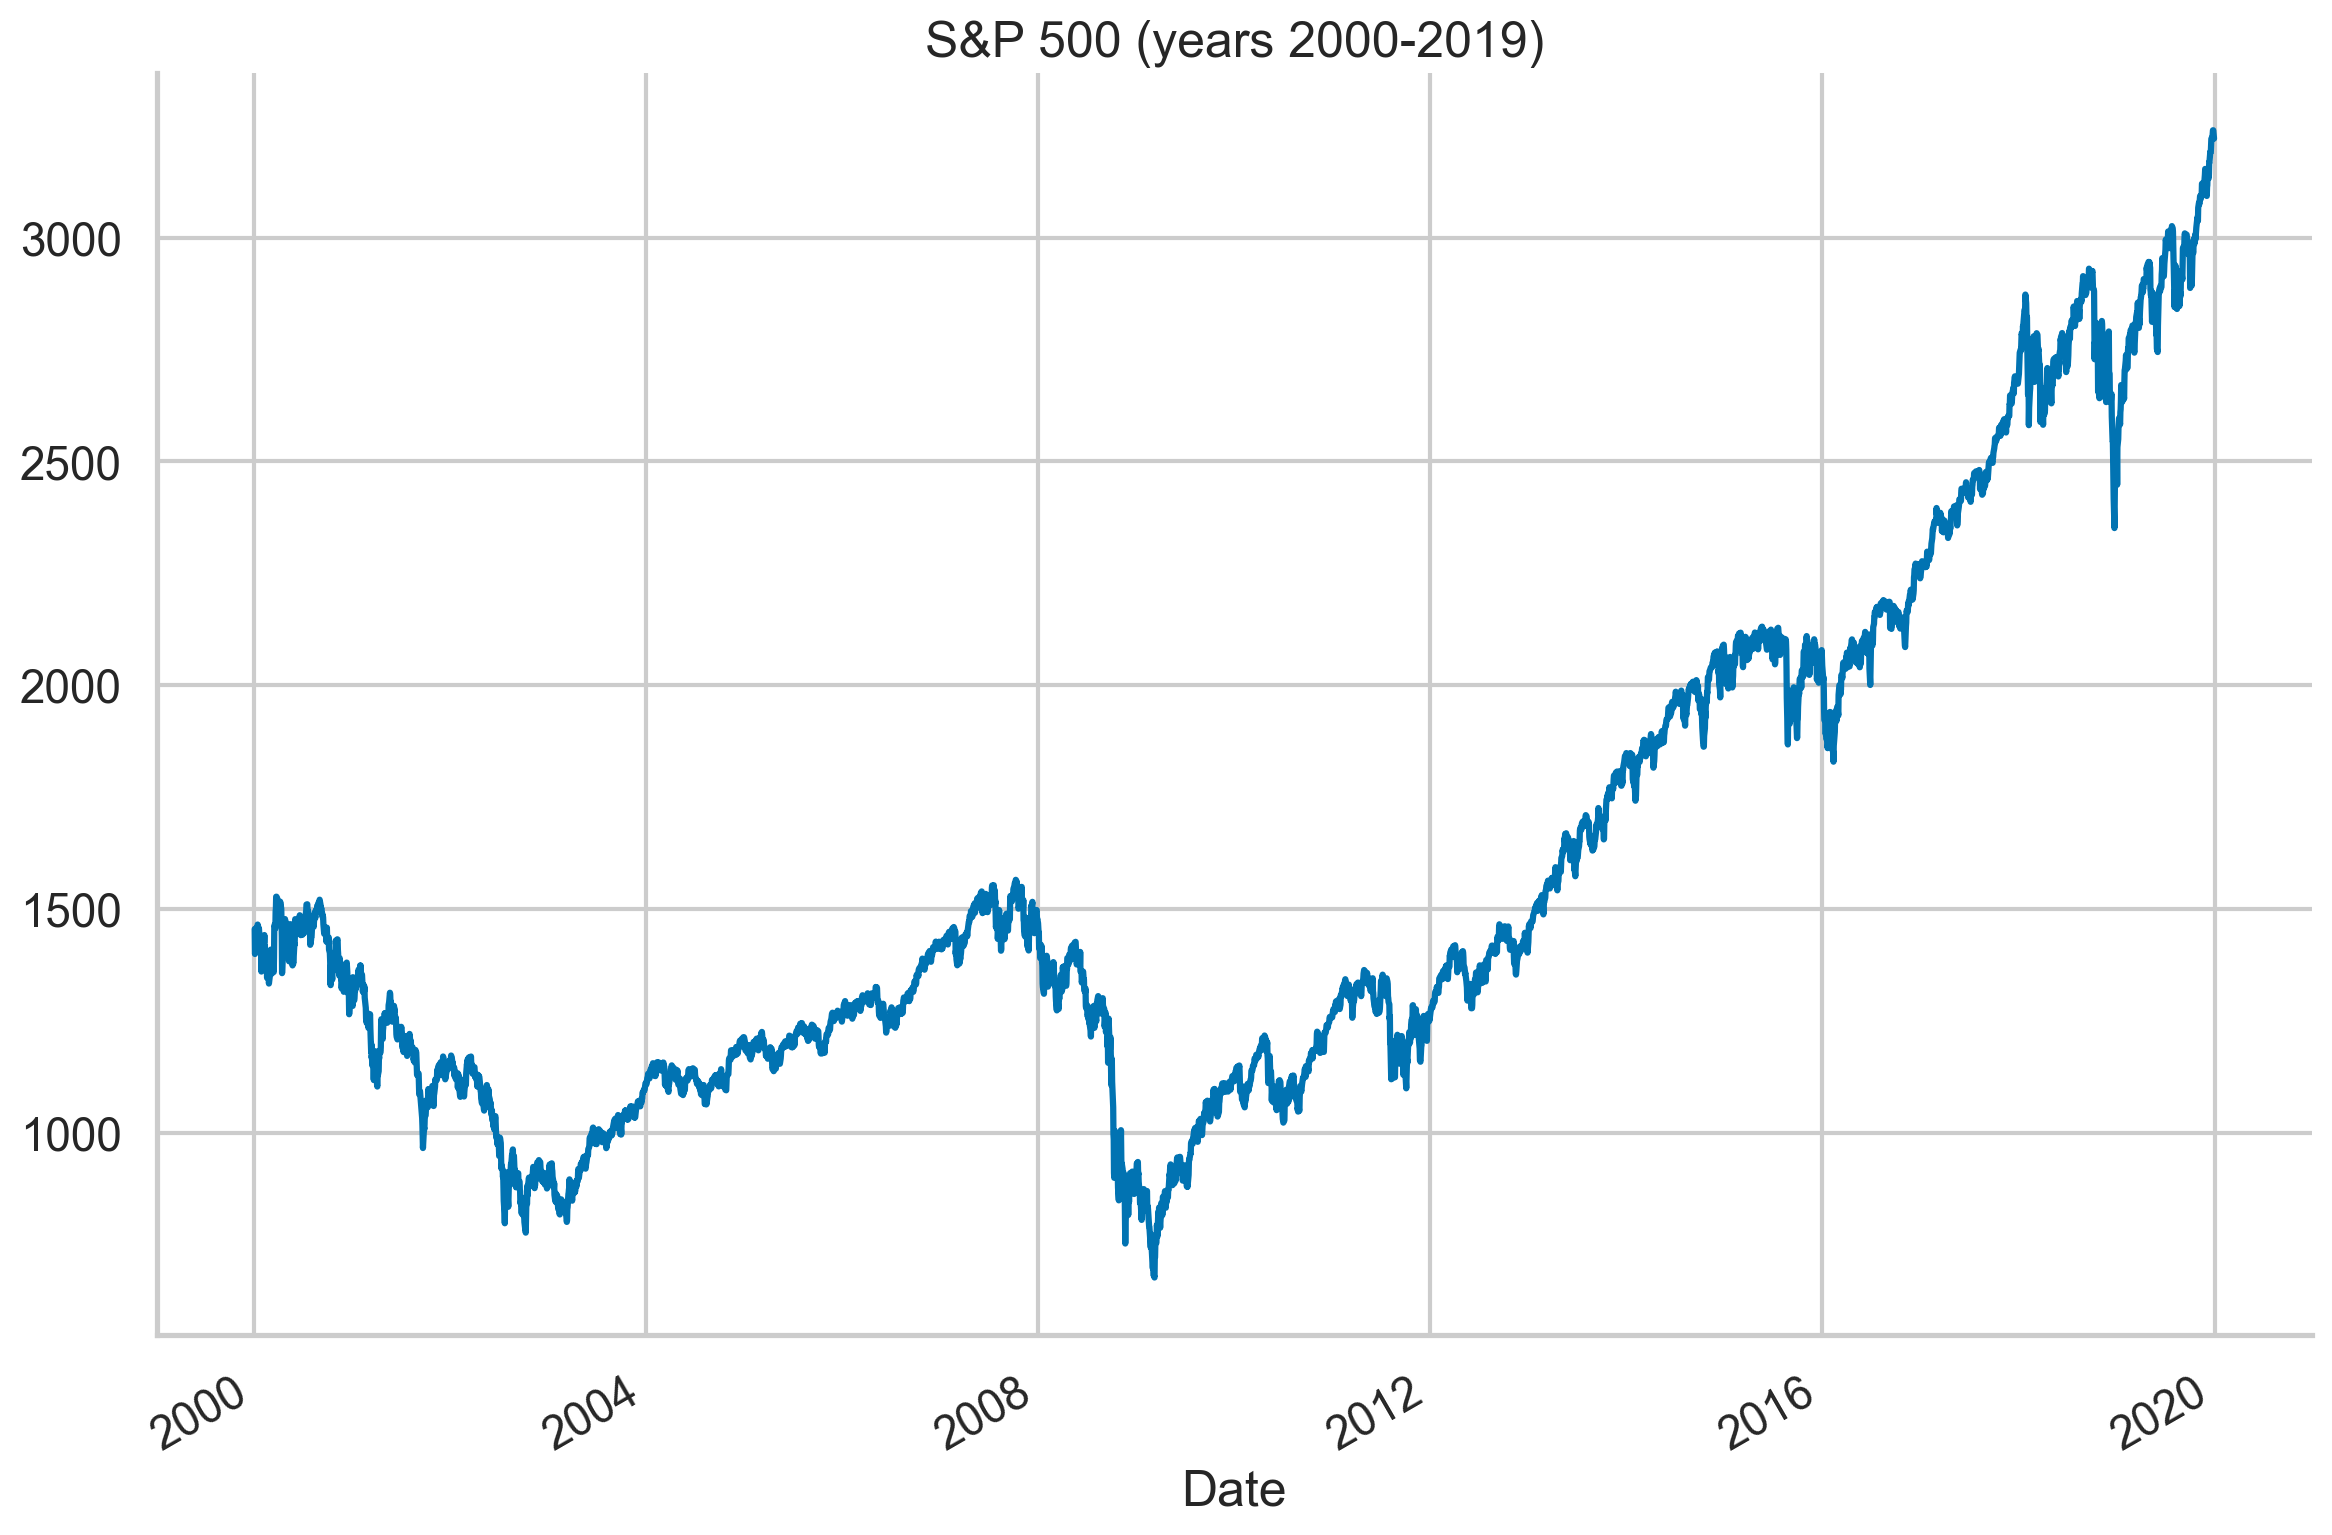

In [43]:
df = yf.download("^GSPC", 
                 start="2000-01-01", 
                 end="2019-12-31", 
                 progress=False)
df["Adj Close"].plot(title="S&P 500 (years 2000-2019)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_9", dpi=200);

Hurst exponent를 계산하는 함수를 구현

In [44]:
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # standard deviations of the lagged differences
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]

    return hurst_exp

여러 가지의 max lag 값으로 Hurst exponent 값을 구해 본다.

In [45]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.4481
Hurst exponent with 100 lags: 0.4513
Hurst exponent with 250 lags: 0.4918
Hurst exponent with 500 lags: 0.5265
Hurst exponent with 1000 lags: 0.5178


2005년부터 2007년으로 데이터 범위를 줄여서 Hurst exponent를 여러 max lag 값으로 계산해 본다.

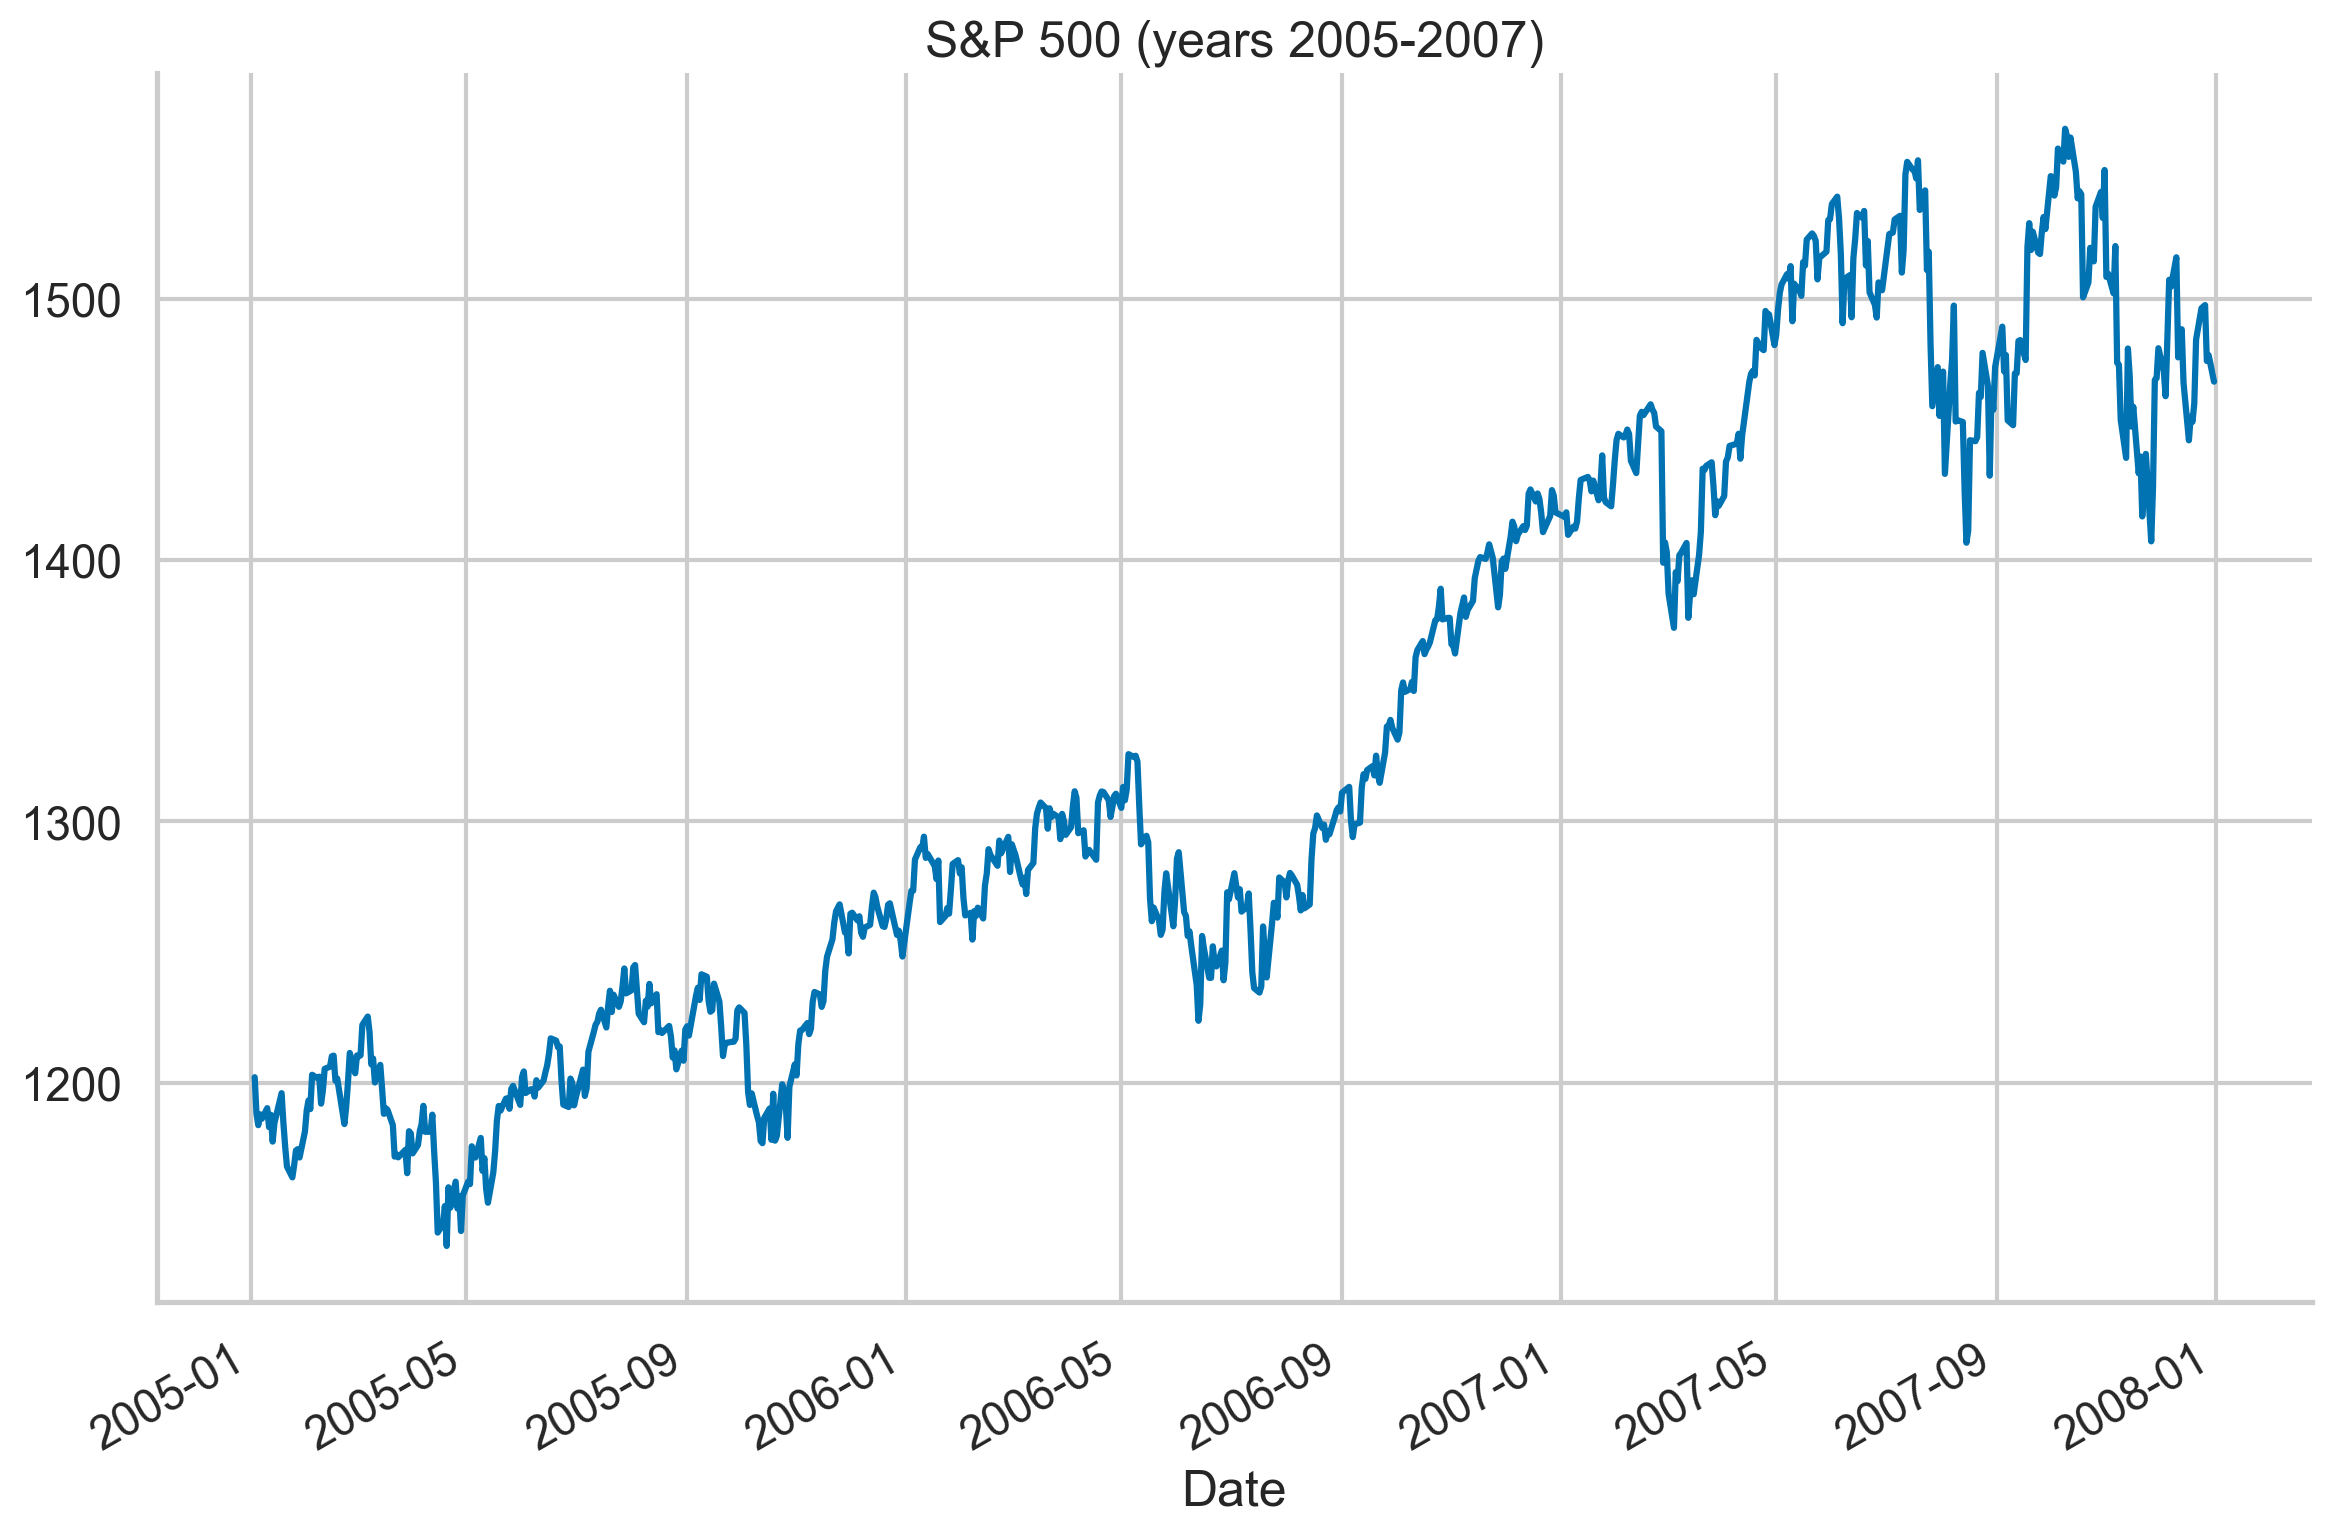

In [46]:
df.loc["2005":"2007", "Adj Close"].plot(title="S&P 500 (years 2005-2007)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_10", dpi=200);

In [47]:
shorter_series = df.loc["2005":"2007", "Adj Close"].values
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.3989
Hurst exponent with 100 lags: 0.3215
Hurst exponent with 250 lags: 0.2507
Hurst exponent with 500 lags: 0.1258


## 4.6 Investigating stylized facts of asset returns

2000년부터 2020년까지의 S&P 500 지수를 이용해서 자산 수익률에 대한 여러가지 정형화된 사실들을 확인해 본다.

- Fact 1: 수익률은 가우시안 분포가 아니다
- Fact 2: 변동성이 몰려 있다.
- Fact 3: 수익률은 자기상관 관계가 없다.
- Fact 4: 제곱/절대 수익률은 작고 감소하는 자기상관 값을 갖는다
- Fact 5: 지렛대 효과

1. Import the libraries:

In [48]:
import pandas as pd 
import numpy as np
import yfinance as yf
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

2. Download the S&P 500 data and calculate the returns:

In [49]:
df = yf.download("^GSPC", 
                 start="2000-01-01", 
                 end="2020-12-31",
                 progress=False)

df = df[["Adj Close"]].rename(
    columns={"Adj Close": "adj_close"}
)
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))
df = df[["adj_close", "log_rtn"]].dropna()
df

adj_close   log_rtn
Date                             
2000-01-04  1399.420044 -0.039099
2000-01-05  1402.109985  0.001920
2000-01-06  1403.449951  0.000955
2000-01-07  1441.469971  0.026730
2000-01-10  1457.599976  0.011128
...                 ...       ...
2020-12-23  3690.010010  0.000746
2020-12-24  3703.060059  0.003530
2020-12-28  3735.360107  0.008685
2020-12-29  3727.040039 -0.002230
2020-12-30  3732.040039  0.001341

[5282 rows x 2 columns]

#### Fact 1 - Non-Gaussian distribution of returns

- Negative skewness: 큰 마이너스 수익률이 큰 플러스 수익률보다 더 자주 발생한다.
- Excess kurtosis: 크거나 작은 수익률이 정규분포보다 더 많다. (더 뾰족한 분포를 보인다) 

수익률 데이터의 평균과 표준편차로 정규분포를 계산한다.

In [50]:
r_range = np.linspace(min(df["log_rtn"]), 
                      max(df["log_rtn"]), 
                      num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

Histogram과 Q-Q Plot을 그린다.

C:\Users\syahn\AppData\Local\Temp\ipykernel_25948\471142876.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.log_rtn, kde=False,
C:\Users\syahn\.conda\envs\cookbook3.8_2\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


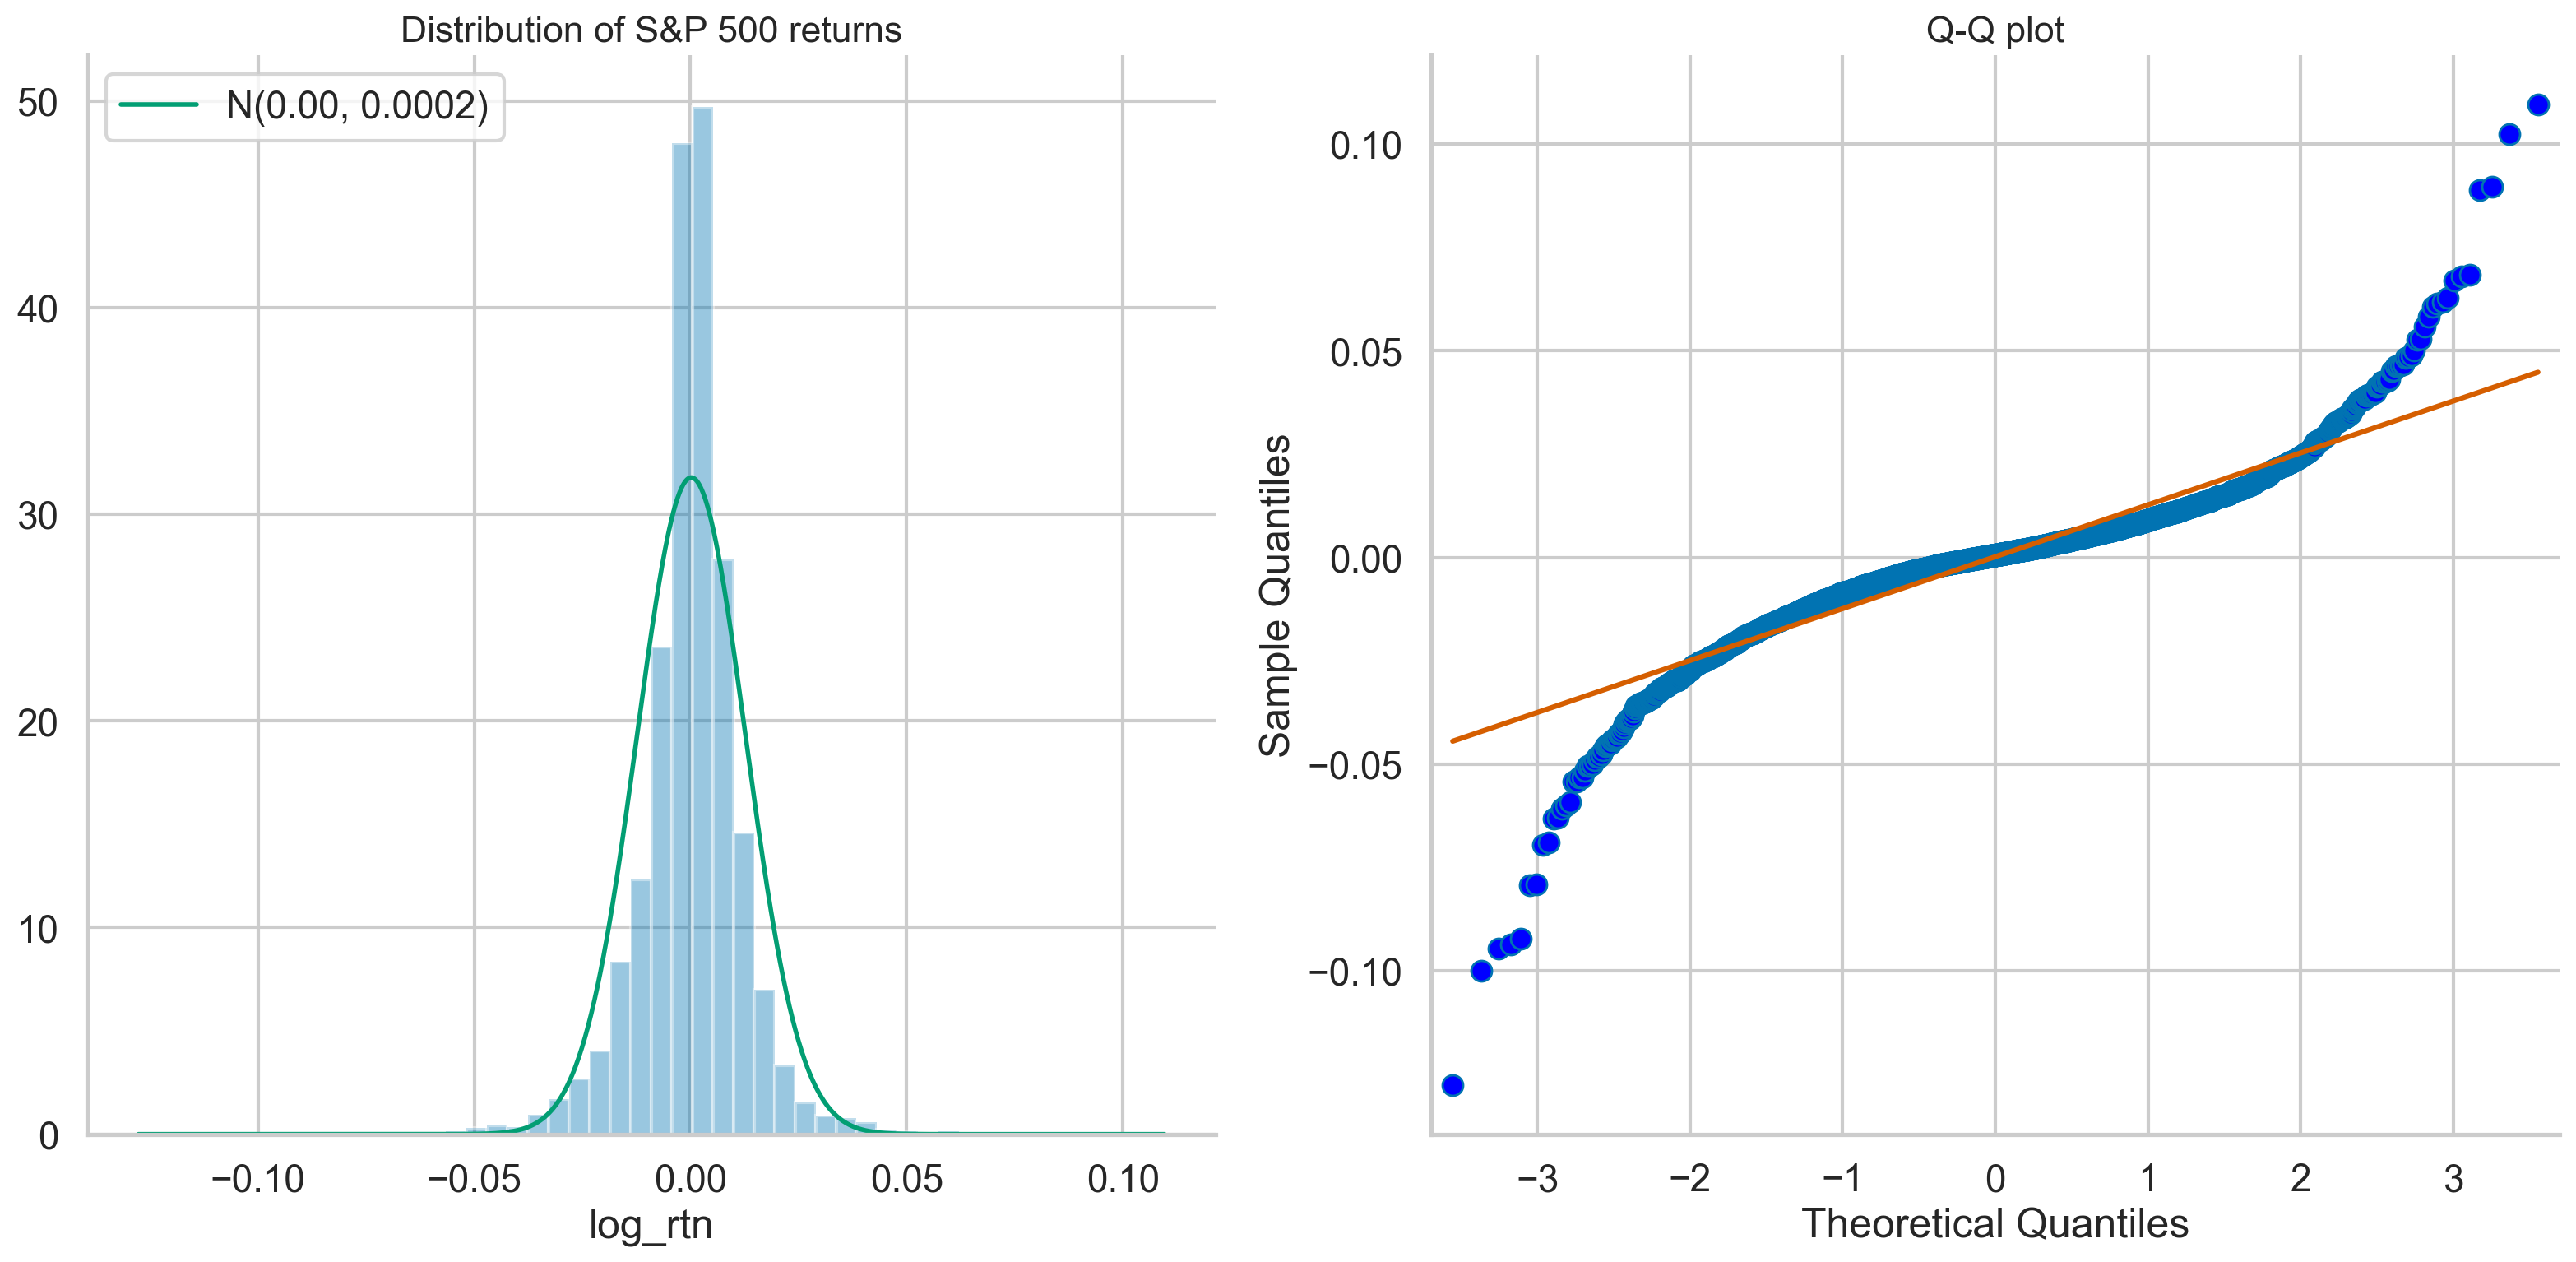

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, 
             norm_hist=True, ax=ax[0])                                    
ax[0].set_title("Distribution of S&P 500 returns", 
                fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, "g", lw=2, 
           label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left");

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize = 16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_11", dpi=200);

In [52]:
jb_test = scs.jarque_bera(df["log_rtn"].values)

print("---------- Descriptive Statistics ----------")
print("Range of dates:", min(df.index.date), "-", max(df.index.date))
print("Number of observations:", df.shape[0])
print(f"Mean: {df.log_rtn.mean():.4f}")
print(f"Median: {df.log_rtn.median():.4f}")
print(f"Min: {df.log_rtn.min():.4f}")
print(f"Max: {df.log_rtn.max():.4f}")
print(f"Standard Deviation: {df.log_rtn.std():.4f}")
print(f"Skewness: {df.log_rtn.skew():.4f}")
print(f"Kurtosis: {df.log_rtn.kurtosis():.4f}") 
print(f"Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}")

---------- Descriptive Statistics ----------
Range of dates: 2000-01-04 - 2020-12-30
Number of observations: 5282
Mean: 0.0002
Median: 0.0006
Min: -0.1277
Max: 0.1096
Standard Deviation: 0.0126
Skewness: -0.3935
Kurtosis: 10.9538
Jarque-Bera statistic: 26487.80 with p-value: 0.00


#### Fact 2 - Volatility Clustering

수익률에 큰 변화가 있으면 큰 변화가 따라오고 작은 변화가 있으면 작은 변화가 따라오는 경향이 있다.  
즉, 변동성이 큰 구간과 변동성이 작은 구간이 있다.

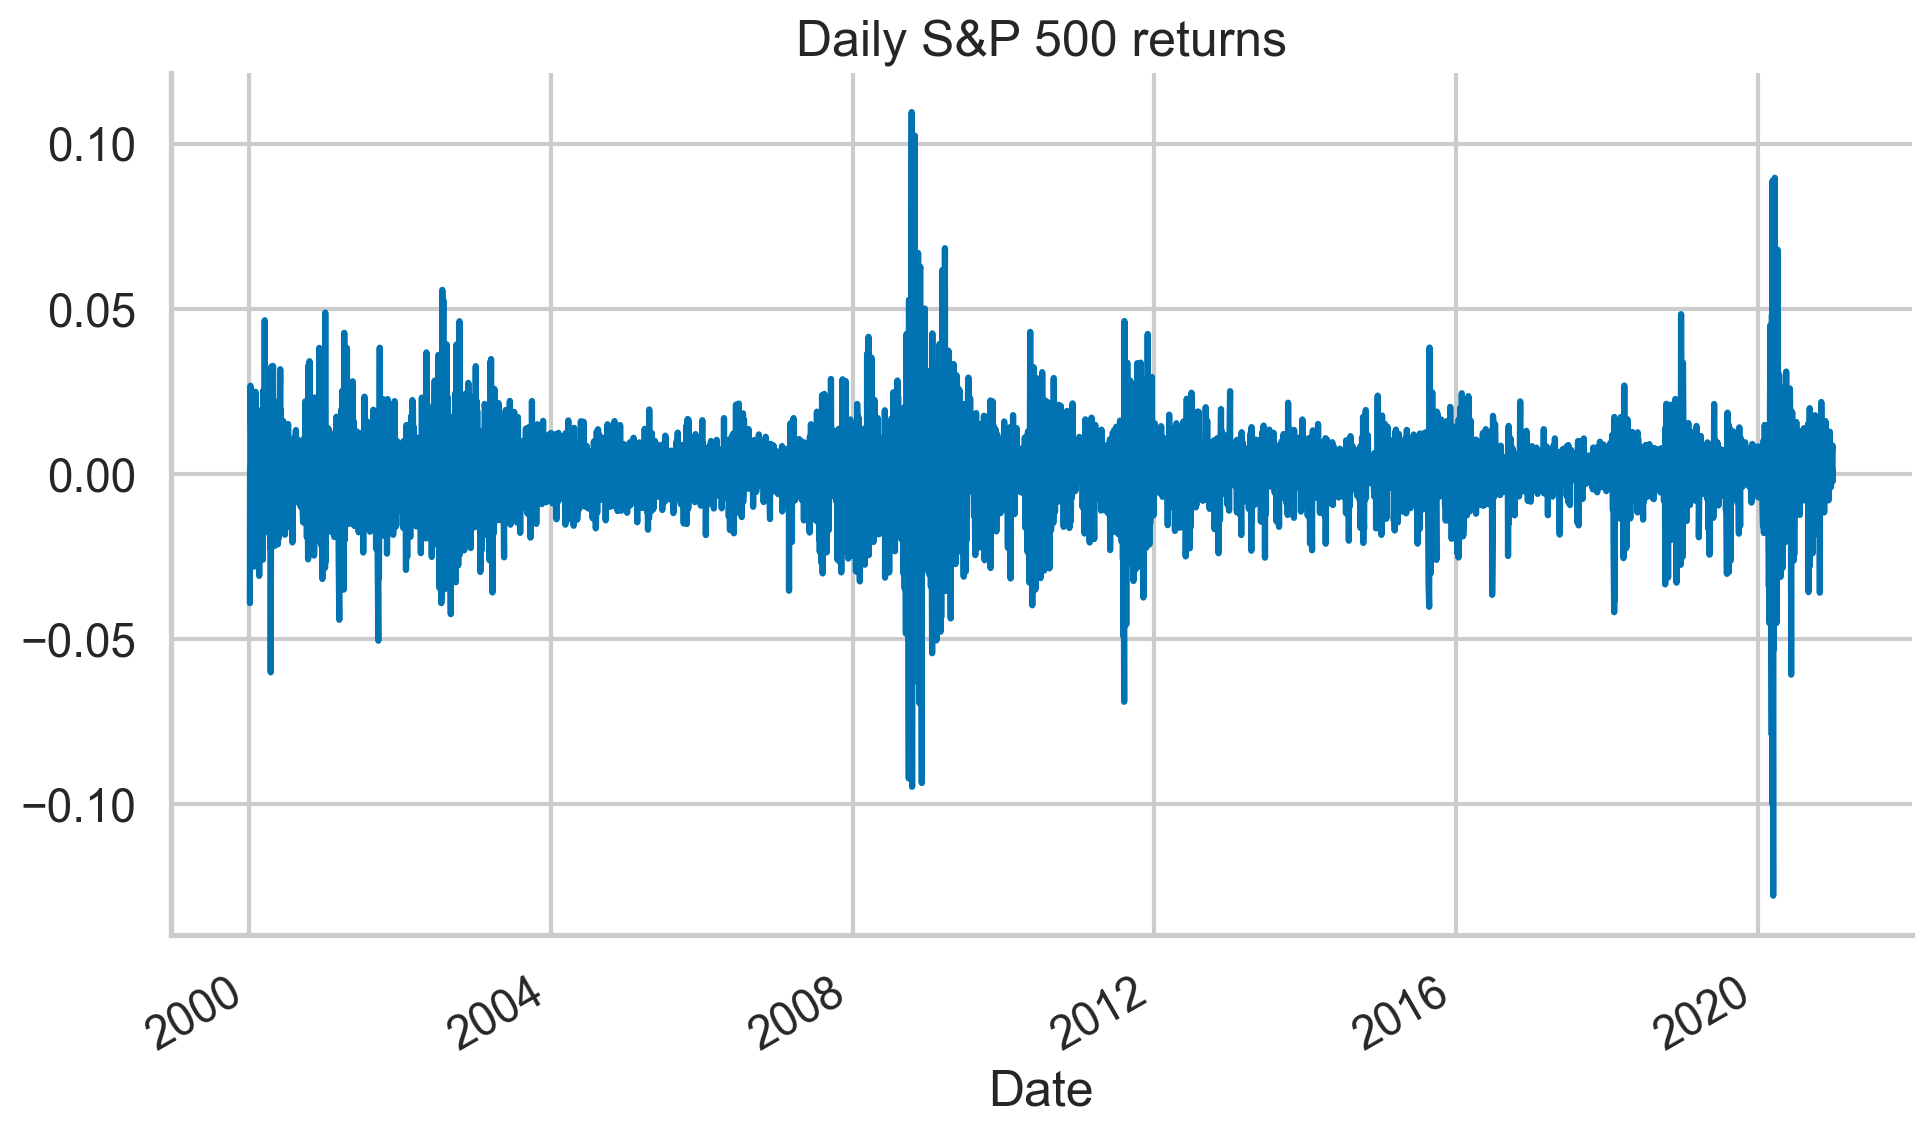

In [53]:
(
    df["log_rtn"]
    .plot(title="Daily S&P 500 returns", figsize=(10, 6))
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_12", dpi=200);

#### Fact 3 - Absence of autocorrelation in returns

수익률은 자기상관관계가 없다.

자기상관관계 그래프를 위한 인자들

In [54]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

자기상관관계 함수를 만들고 그래프를 그려본다.

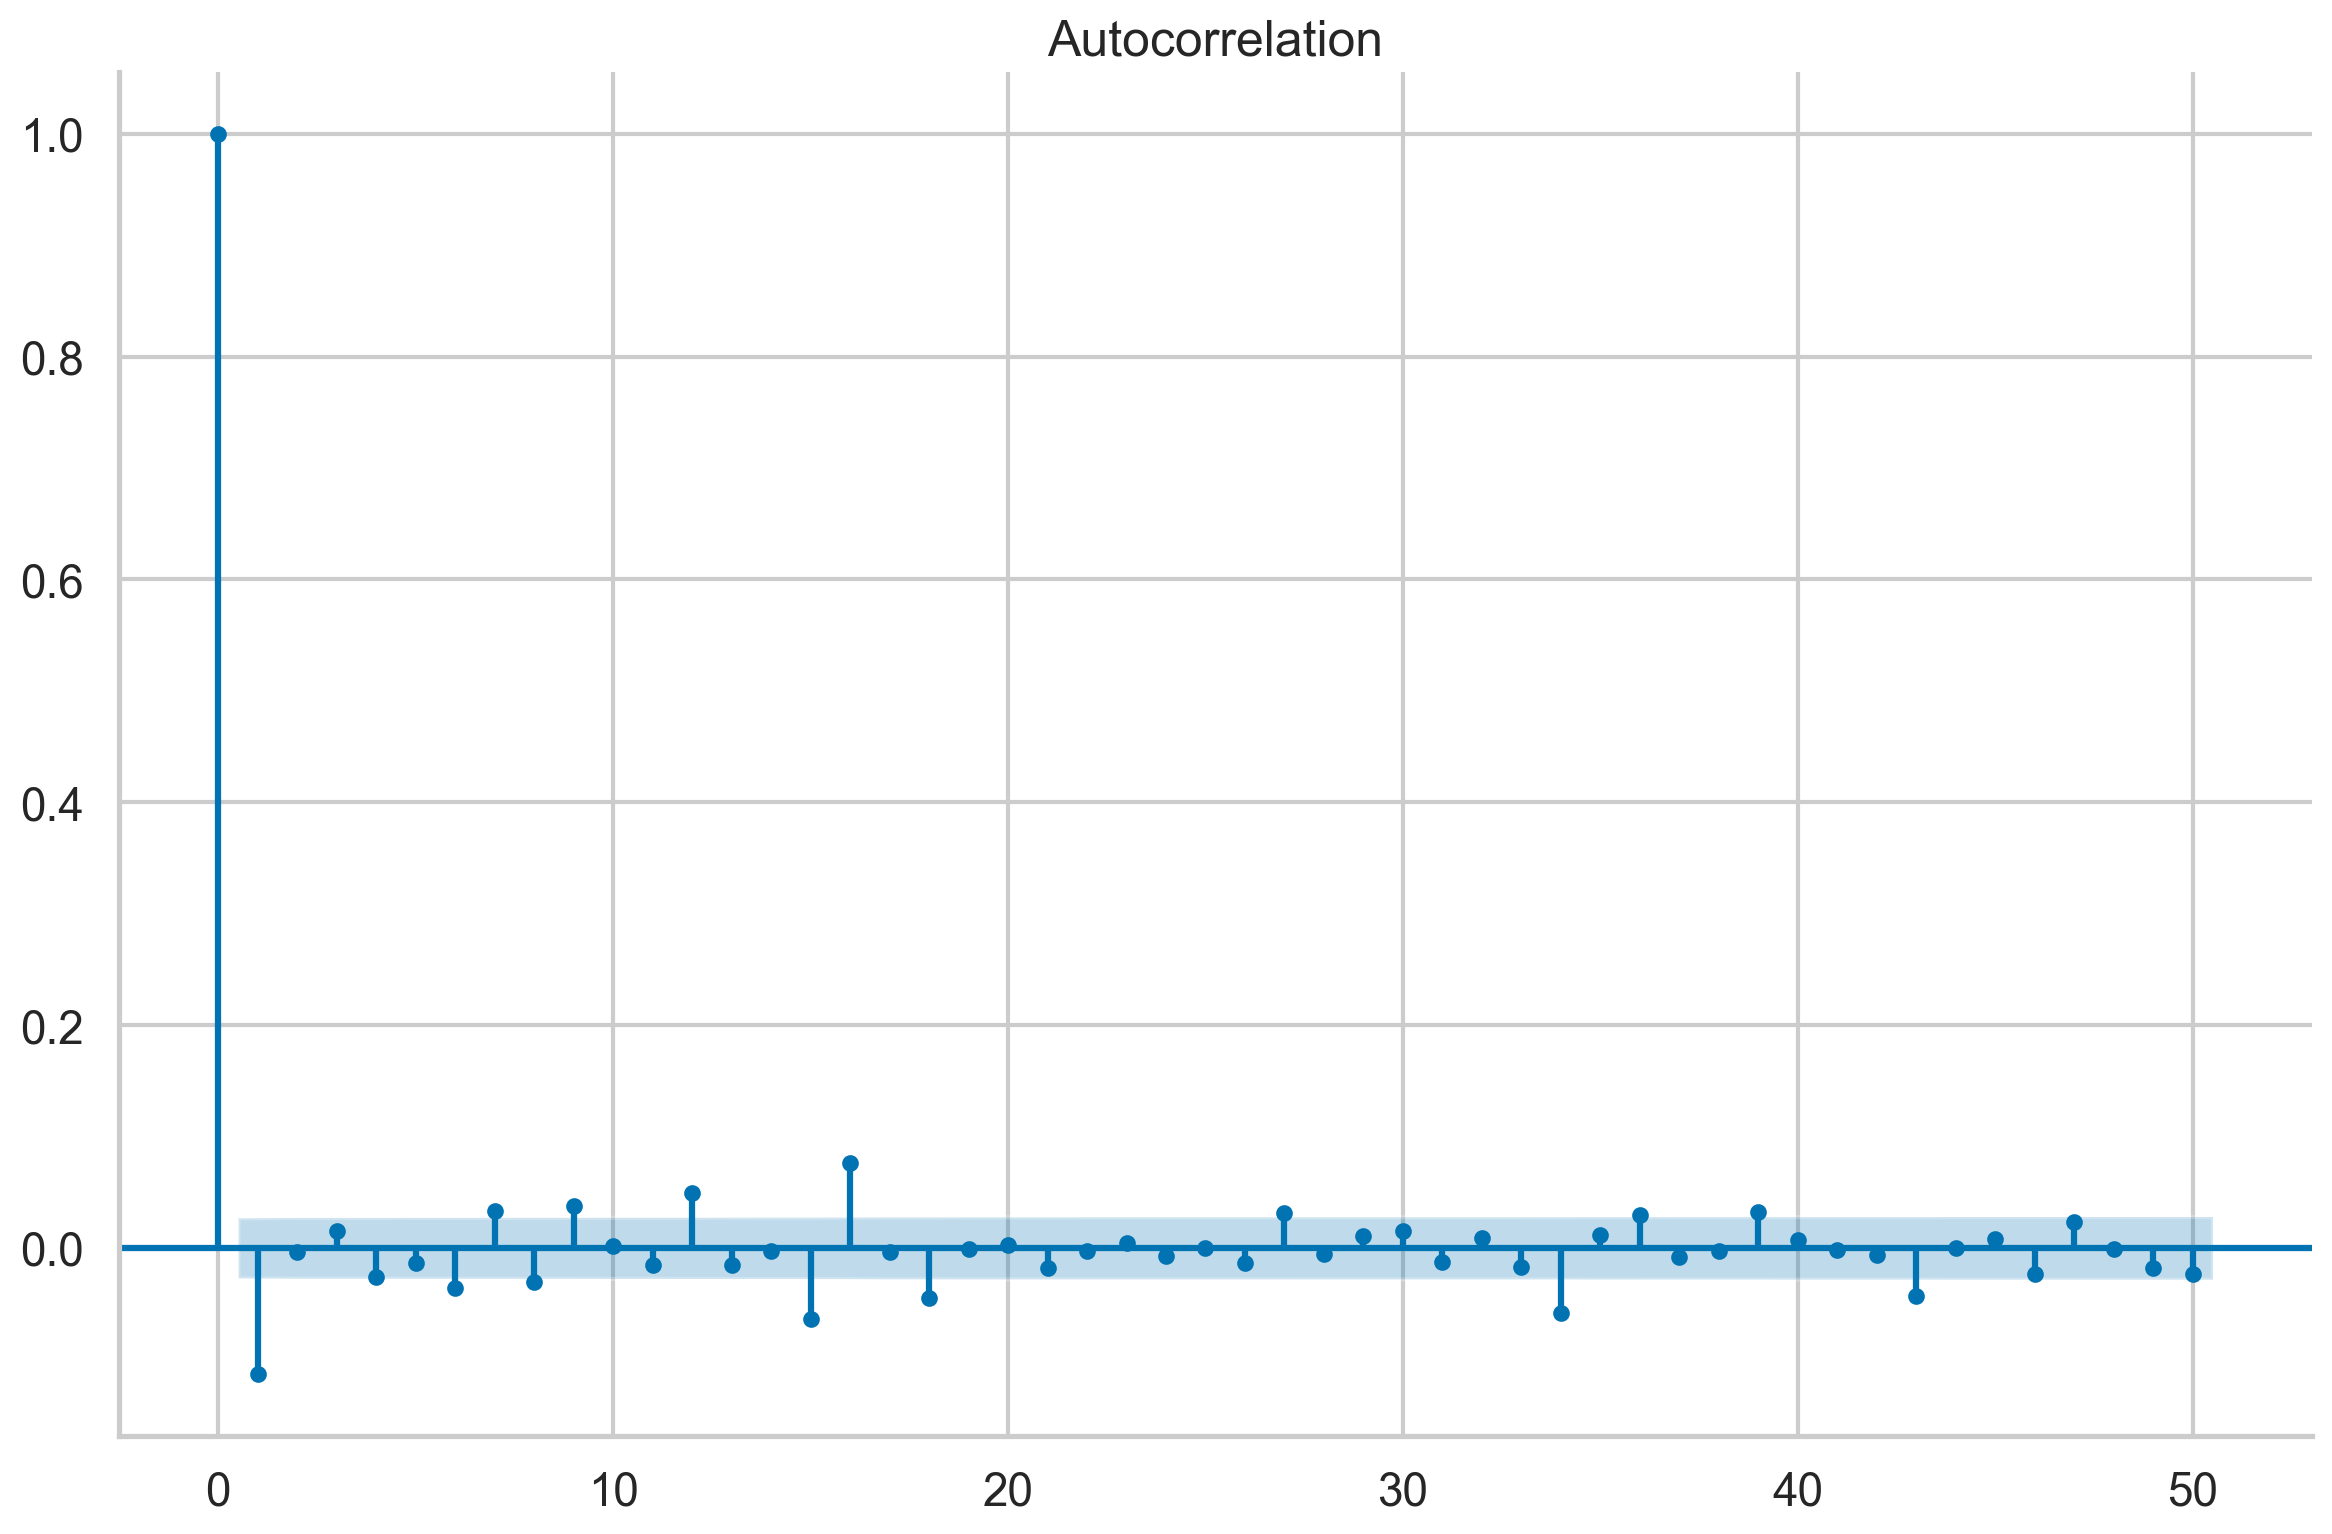

In [55]:
acf = smt.graphics.plot_acf(df["log_rtn"], 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_13", dpi=200);

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns

제곱/절대 수익률의 자기상관관계는 작고 감소하는 경향을 보인다.

제곱/절대 수익률을 계산하고 자기상관 관계 그래프를 그린다.

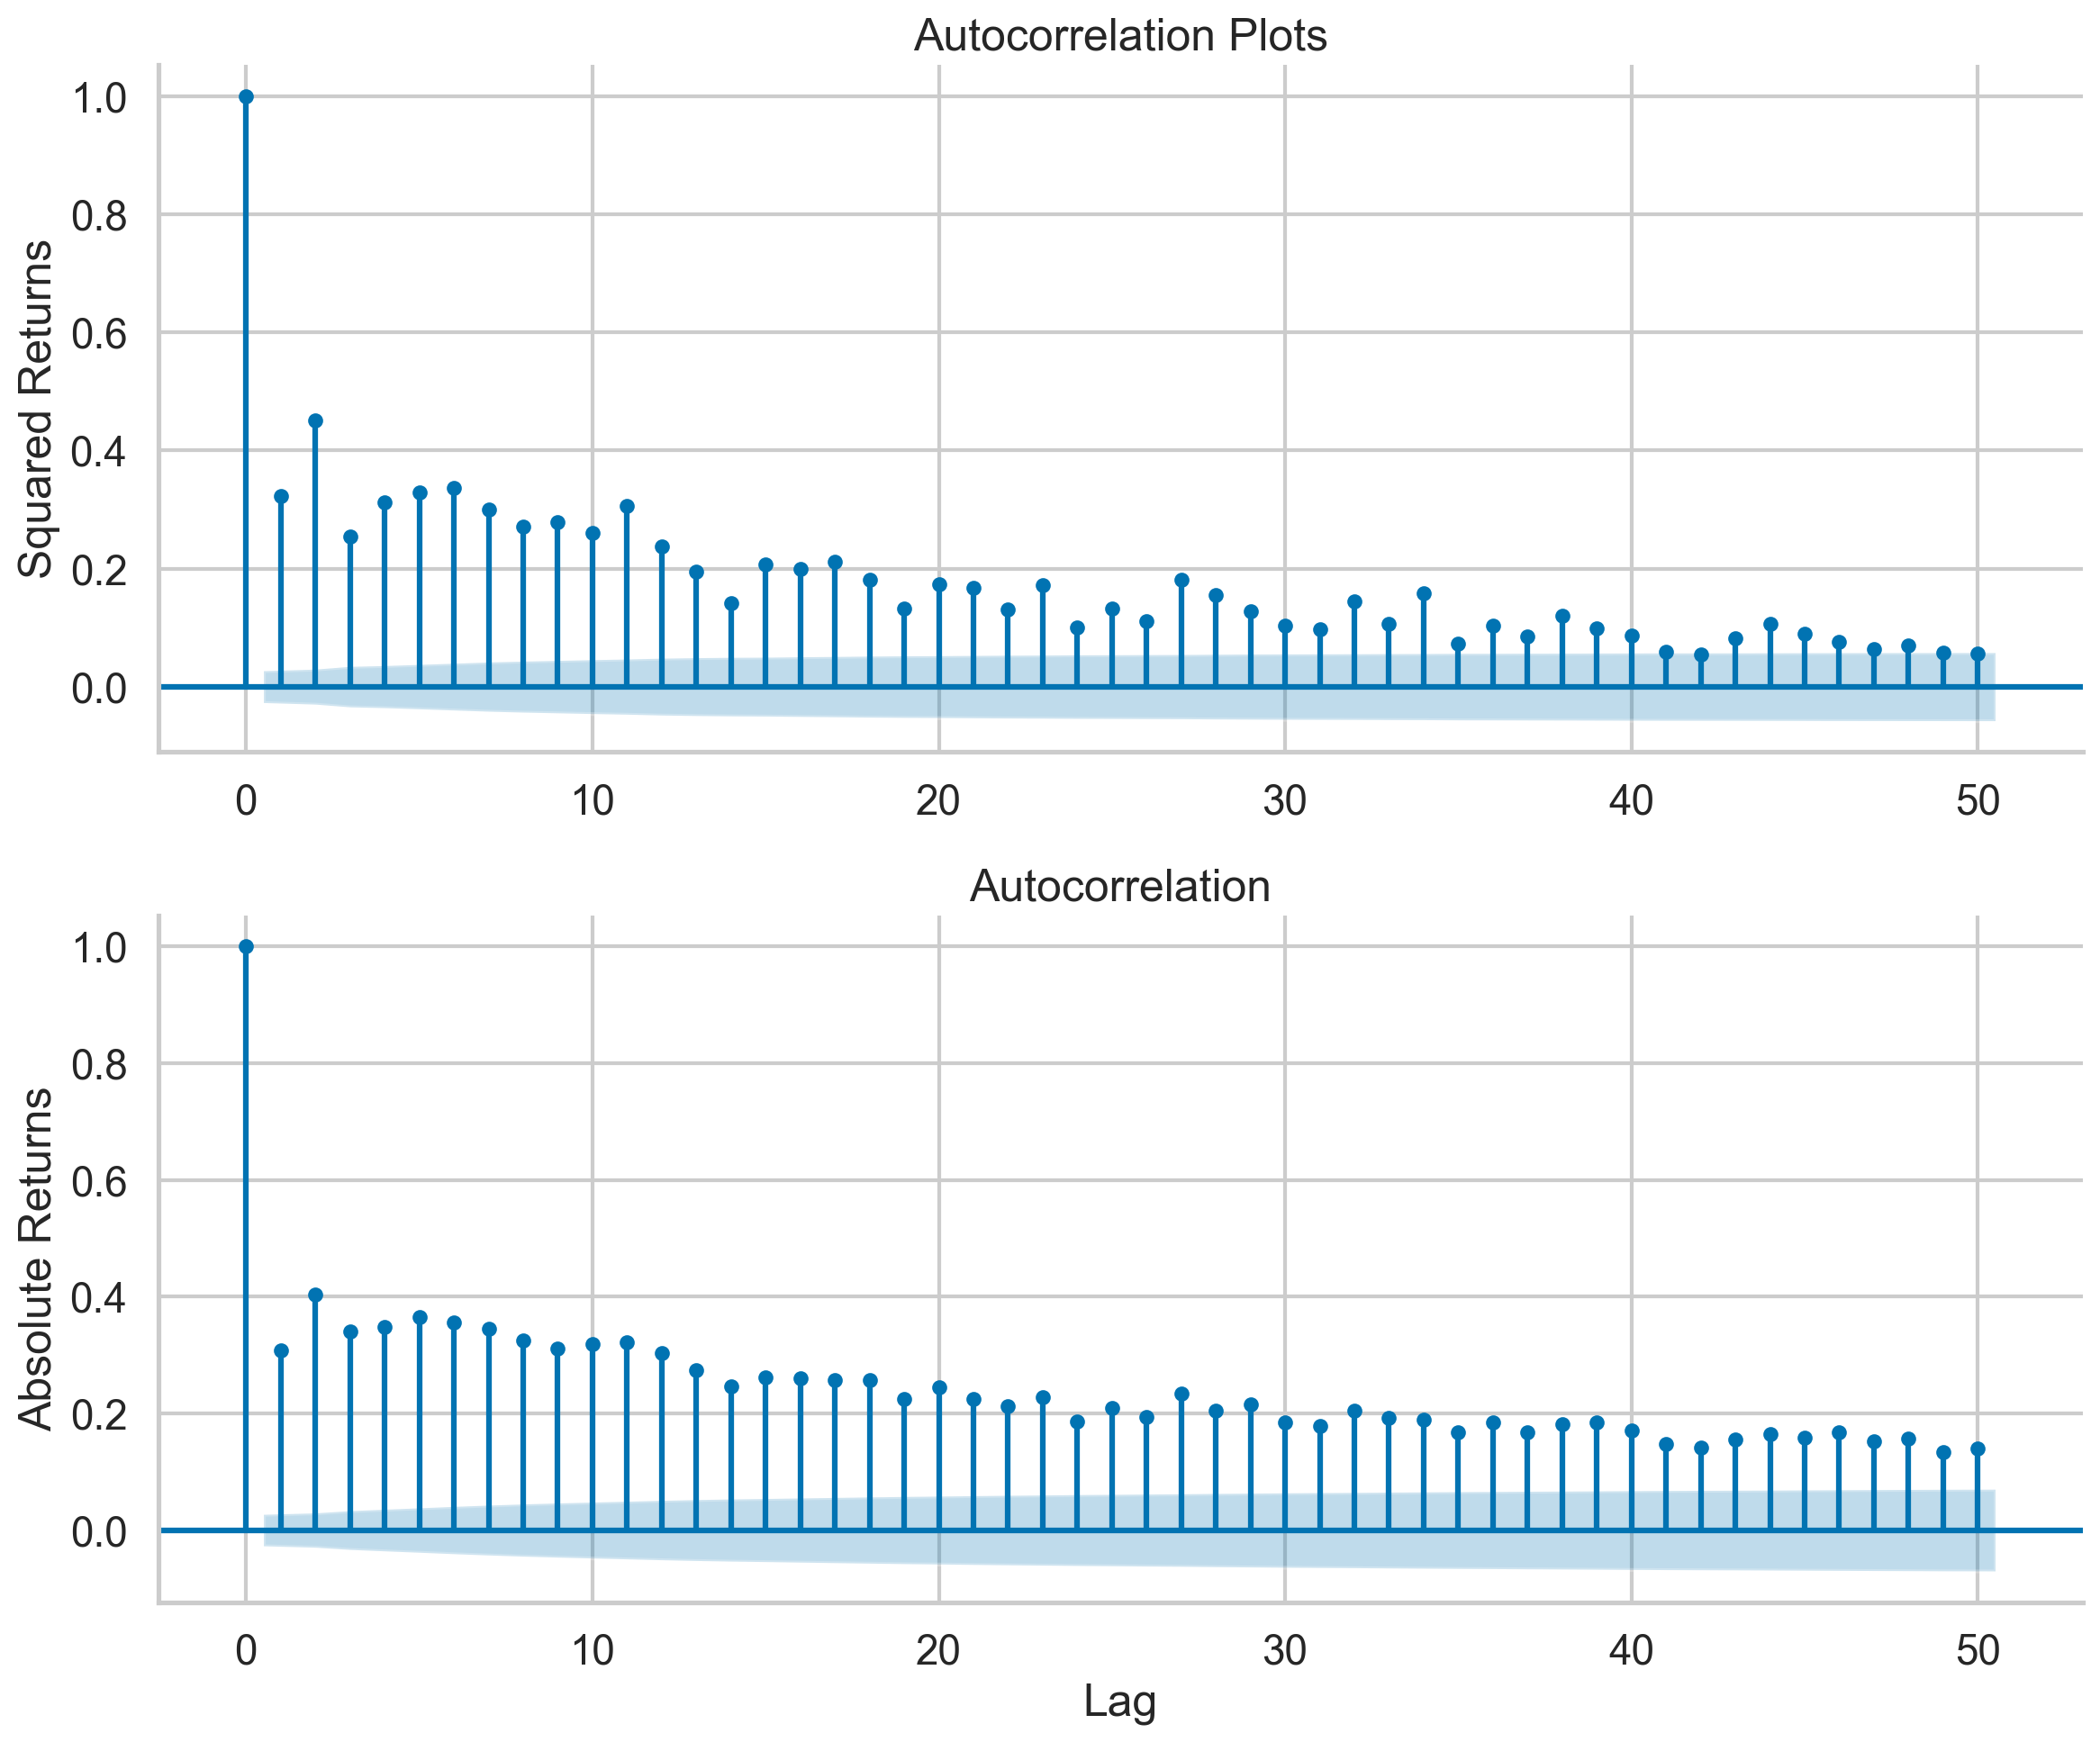

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots",
          ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns",
          xlabel="Lag")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_14", dpi=200);

#### Fact 5 - Leverage effect

수익률이 작을 수록 변동성이 커진다.

로그 수익률의 이동 표준편차를 구한다.

In [57]:
df["rolling_std_252"] = df[["log_rtn"]].rolling(window=252).std()
df["rolling_std_21"] = df[["log_rtn"]].rolling(window=21).std()

그래프로 그려 본다.

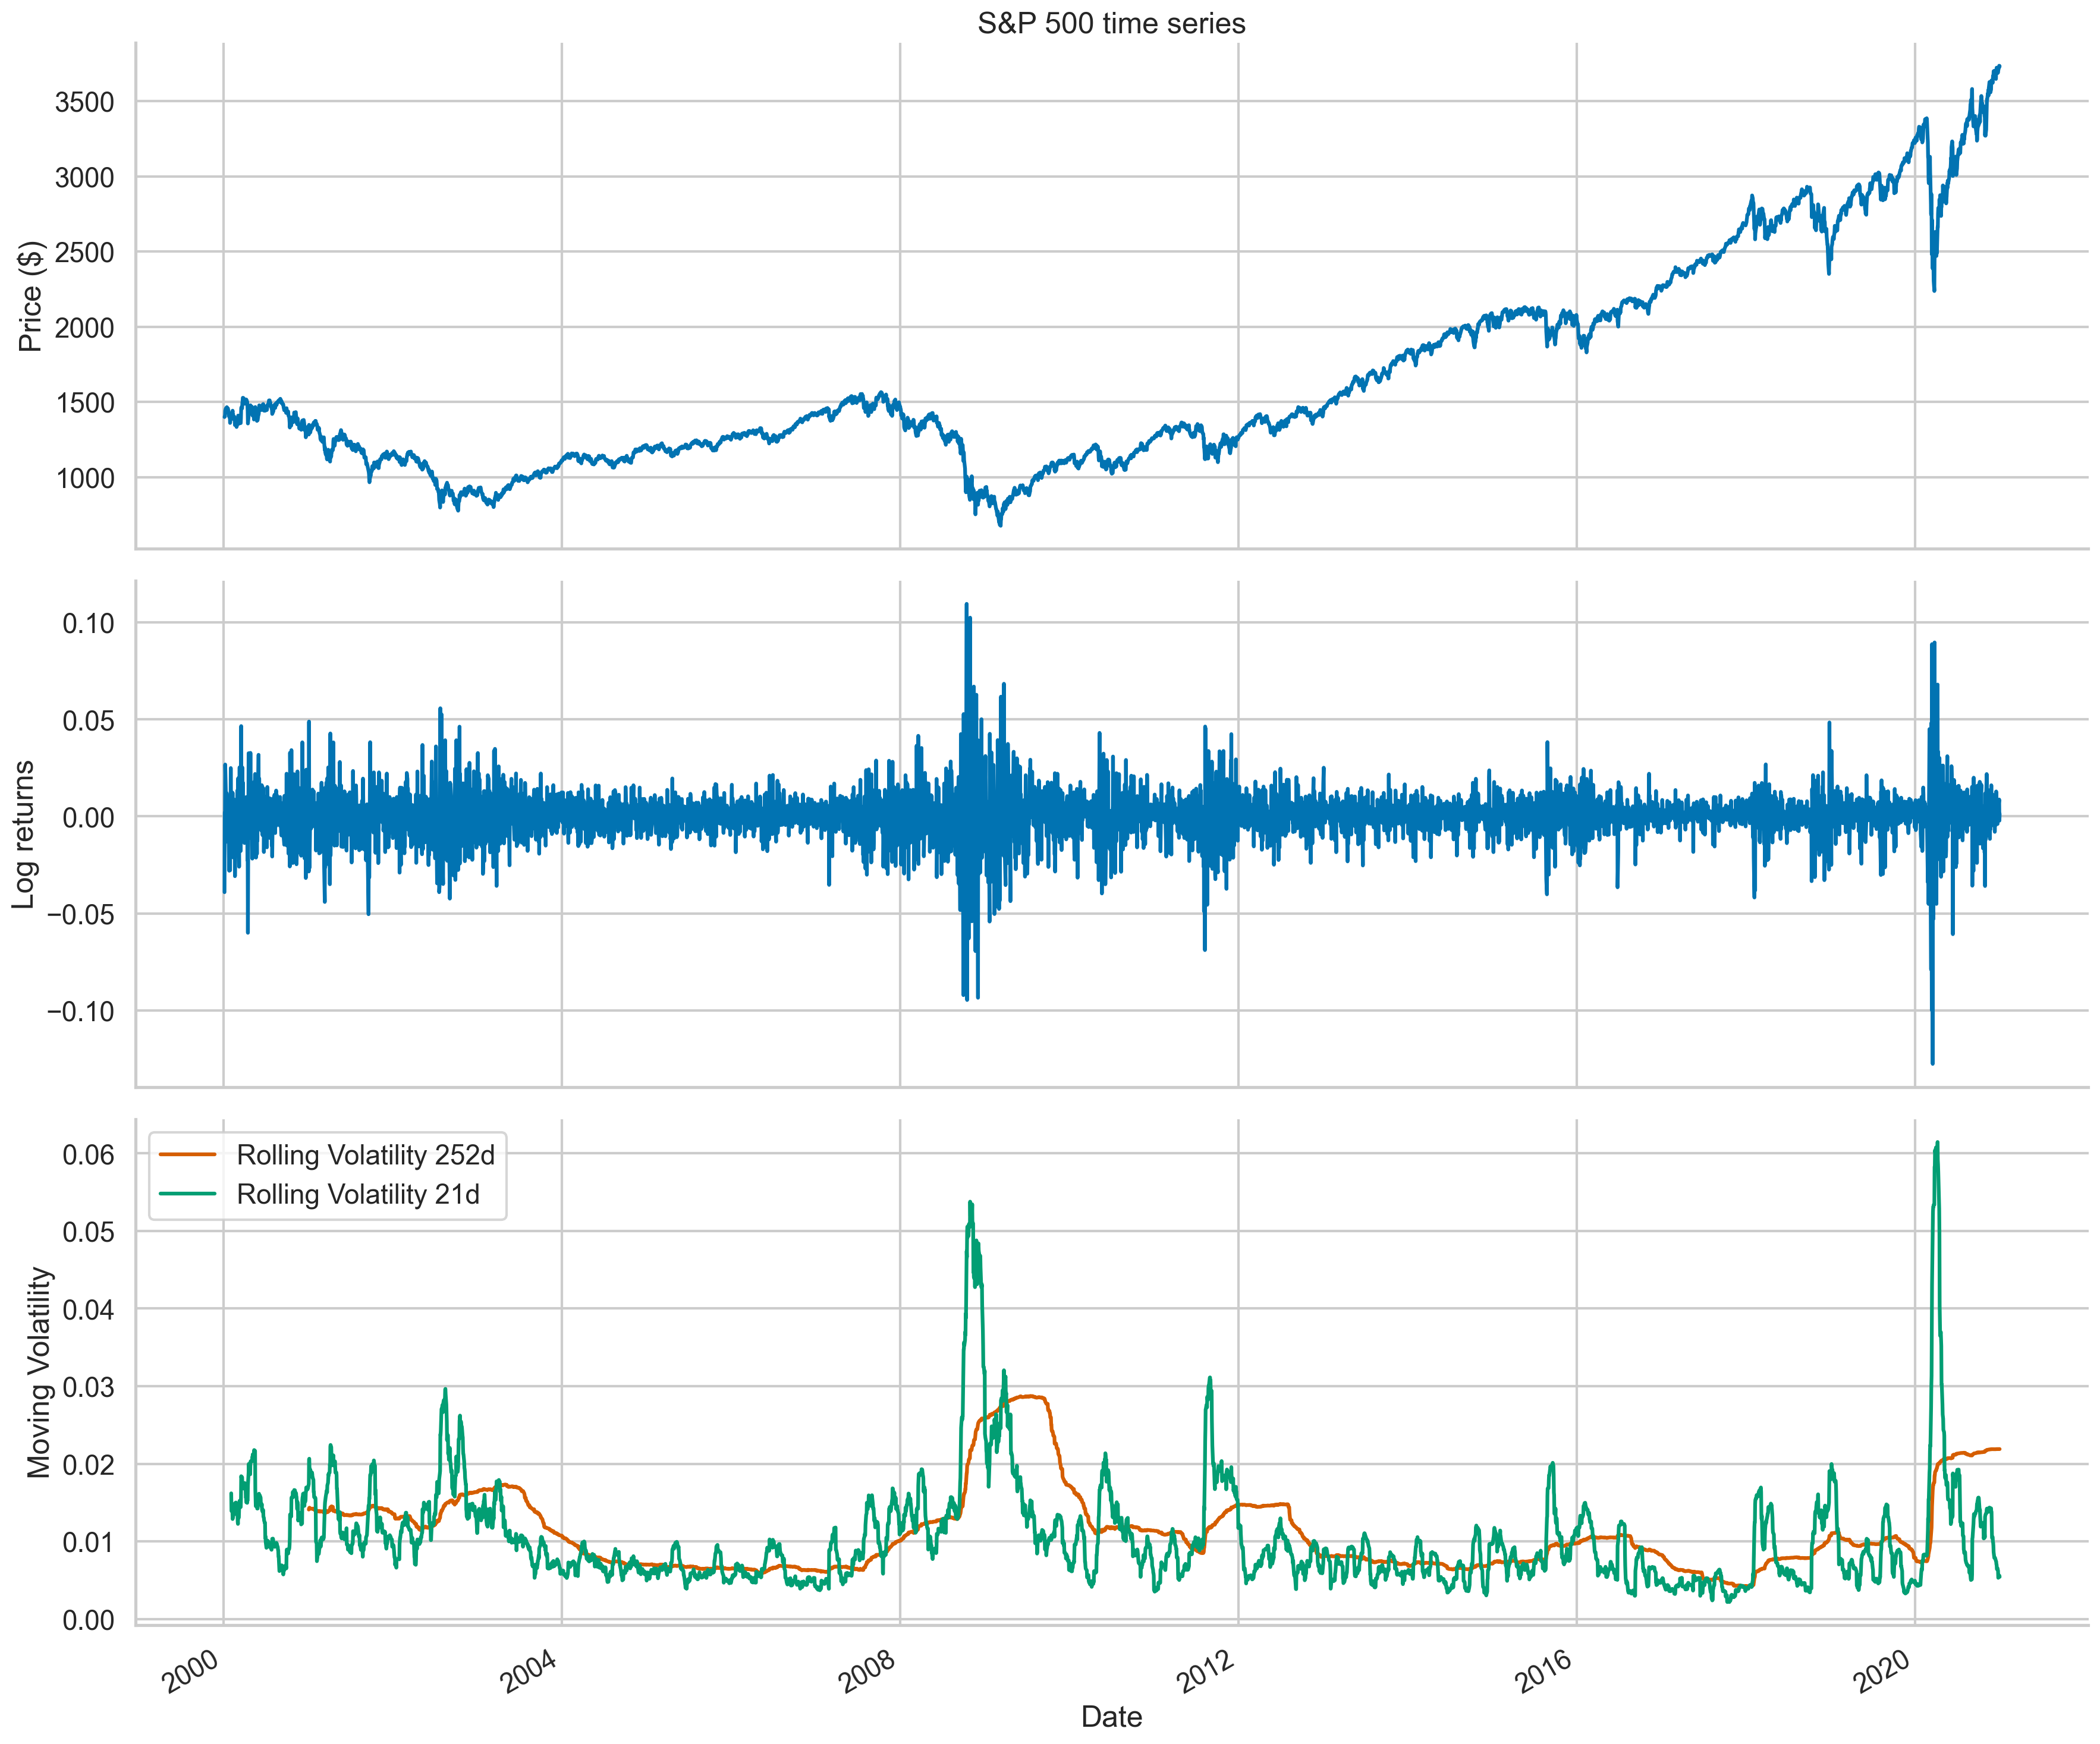

In [58]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), 
                       sharex=True)

df["adj_close"].plot(ax=ax[0])
ax[0].set(title="S&P 500 time series",
          ylabel="Price ($)")

df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")

df["rolling_std_252"].plot(ax=ax[2], color="r", 
                           label="Rolling Volatility 252d")
df["rolling_std_21"].plot(ax=ax[2], color="g", 
                           label="Rolling Volatility 21d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_15", dpi=200);

### There's more

뉴욕시장 변동성 지수(VIX)와 S&P 500 지수를 비교해서 지렛대 효과를 확인해 본다.

S&P 500과 VIX 지수를 얻어온다.

In [59]:
df = yf.download(["^GSPC", "^VIX"], 
                 start="2000-01-01", 
                 end="2020-12-31",
                 progress=False)
df = df[["Adj Close"]]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={"^GSPC": "sp500", "^VIX": "vix"})

각 지수의 로그 수익률을 구한다.

In [60]:
df["log_rtn"] = np.log(df["sp500"] / df["sp500"].shift(1))
df["vol_rtn"] = np.log(df["vix"] / df["vix"].shift(1))
df.dropna(how="any", axis=0, inplace=True)

산포도를 그려보고 회귀선을 구해본다.

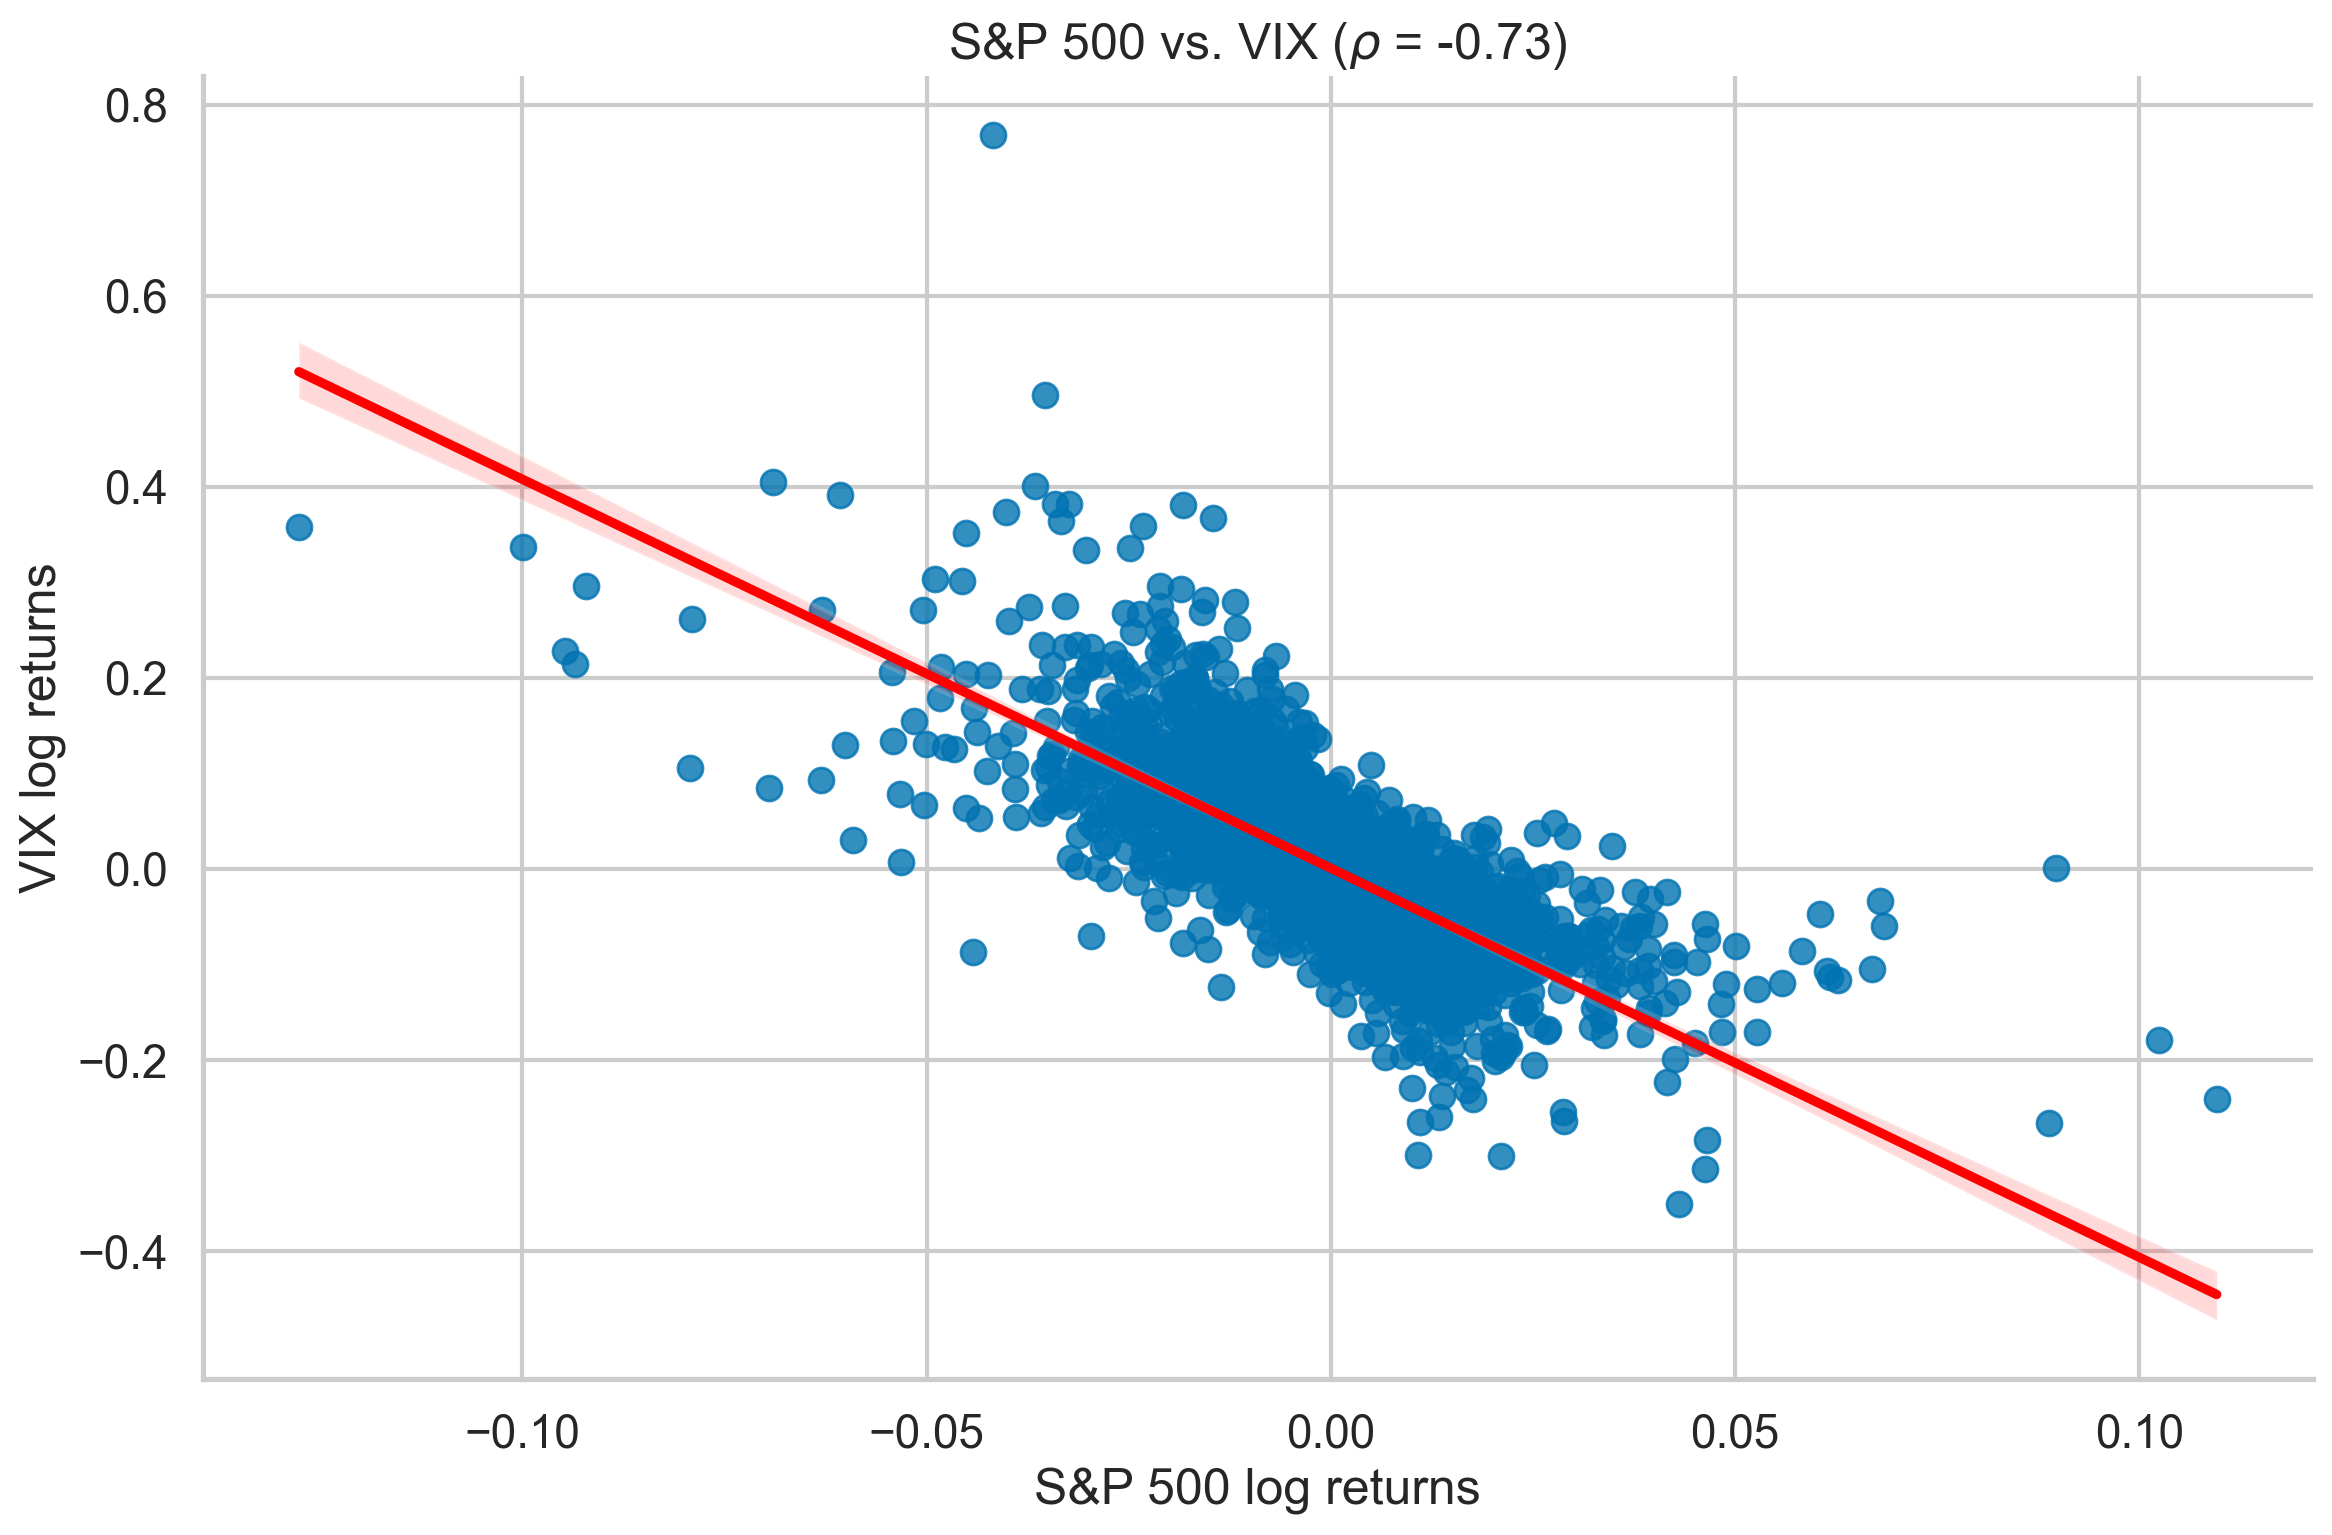

In [61]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x="log_rtn", y="vol_rtn", data=df, 
                 line_kws={"color": "red"})
ax.set(title=f"S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})",
       ylabel="VIX log returns",
       xlabel="S&P 500 log returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_16", dpi=200);

VIX 수익률과 S&P 500 수익률이 음의 상관관계인 것을 확인할 수 있고 지렛대 효과가 있는 것을 알 수 있다.